In [1]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
import matplotlib.patches as mpatches

In [2]:
# Get the current working directory
cwd = os.path.normpath(os.path.dirname(os.getcwd()))

def load_csv(file_path):
    """
    Function to load a CSV file into a pandas DataFrame.
    """
    full_path = os.path.join(cwd, file_path)
    return pd.read_csv(full_path, index_col=0)

def process_dataframe(df, scenario, metric='rmse'):
    """
    Function to process a DataFrame and return average metrics along with boxplot statistics for RMSE.
    """
    # Calculate average metrics for 'train_time' and 'avg_time_epoch'
    average_metrics = df.groupby('architecture').agg({
        'train_time': 'mean',
        'avg_time_epoch': 'mean'
    }).reset_index()

    # Calculate boxplot statistics for RMSE
    stats = df.groupby('architecture')[metric].describe(percentiles=[.25, .5, .75])
    stats = stats[['min', '25%', '50%', '75%', 'max']]

    # Merge the average metrics with RMSE stats
    combined_metrics = pd.merge(average_metrics, stats, on='architecture')

    # Add model_type column
    combined_metrics['model_type'] = scenario

    return combined_metrics

def process_dataframe_clusterwise(df, cluster_users, scenario, cluster_id, metric='rmse'):
    """
    Function to process a DataFrame for a specific cluster and return average metrics along with boxplot statistics for RMSE.
    """
    # Filter DataFrame for users in the cluster
    df_cluster = df[df['user'].isin(cluster_users)]

    # Calculate average metrics for 'train_time' and 'avg_time_epoch'
    average_metrics = df_cluster.groupby('architecture').agg({
        'train_time': 'mean',
        'avg_time_epoch': 'mean'
    }).reset_index()

    # Calculate boxplot statistics for RMSE
    stats = df_cluster.groupby('architecture')[metric].describe(percentiles=[.25, .5, .75])
    stats = stats[['min', '25%', '50%', '75%', 'max']]

    # Merge the average metrics with RMSE stats
    combined_metrics = pd.merge(average_metrics, stats, on='architecture')

    # Add model_type and cluster columns
    combined_metrics['model_type'] = scenario
    combined_metrics['cluster'] = cluster_id

    return combined_metrics

In [3]:
# Define file paths for each CSV file
file_paths = {
    'FL_Grossload': [
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv', 
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Grossload': [
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Grossload_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_Prosumption': [
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Prosumption_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Prosumption': [
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Prosumption_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_PV': [
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_PV_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_PV': [
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_PV_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ],
    'FL_Totalload': [
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_cnn_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Benchmark/wandb/global_transformer_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_soft_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_topk_bilstm_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_soft_dense_all_results.csv',
        'Federatedlearning/TS_FL_Totalload_Forecasting_Moe/wandb/global_topk_dense_all_results.csv'
    ],
    'LL_Totalload': [
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/bilstm_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/cnn_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Benchmark/wandb/transformer_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/lstm_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/lstm_topk_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/dense_soft_moe_all_results.csv',
        'Locallearning/TS_LL_Totalload_Forecasting_Moe/wandb/dense_topk_moe_all_results.csv'
    ]
}


# 0. Plot time series

In [4]:
import tensorflow as tf
import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *
from utils.federatedrunner import *

num_users = 30
sequence_length = 25
batch_size = 16
horizon = 1
max_epochs = 100

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

custom_objects = {
                'EinsumLayer': EinsumLayer,
                'TopKLayer': TopKLayer,
                'ImportanceRegularizationLayer': ImportanceRegularizationLayer
                }

In [5]:
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index
start_date = df.index.min()
# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)
# Filter the dataframe to only include the first year of data
df = df[(df.index >= start_date) & (df.index < end_date)]

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

#Train, Validation and Test datasets
X_load_train, y_load_train, X_load_val, y_load_val, X_load_test, y_load_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = min_max_scaling(train_df)
    val_df = min_max_scaling(val_df)
    test_df = min_max_scaling(test_df)

    # Sequencing
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    test_sequences = create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_load_train[f'user{idx+1}'], y_load_train[f'user{idx+1}'] = prepare_data(train_sequences, batch_size)
    X_load_val[f'user{idx+1}'], y_load_val[f'user{idx+1}'] = prepare_data(val_sequences, batch_size)
    X_load_test[f'user{idx+1}'], y_load_test[f'user{idx+1}'] = prepare_data(test_sequences, batch_size)

dense_soft_model = tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_soft_dense_c6_FLround3.keras", compile=False, custom_objects=custom_objects)
dense_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

dense_topk_model = tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_topk_dense_c6_FLround3.keras", compile=False, custom_objects=custom_objects)
dense_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_soft_model =  tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_soft_bilstm_c6_FLround3.keras", compile=False, custom_objects=custom_objects)
bilstm_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_topk_model =  tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_topk_bilstm_c6_FLround3.keras", compile=False, custom_objects=custom_objects)
bilstm_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

user = 'user10'
pred_load_dense_soft_model = dense_soft_model.predict(X_load_test[user], batch_size=batch_size)
pred_load_dense_topk_model = dense_topk_model.predict(X_load_test[user], batch_size=batch_size)
pred_load_bilstm_soft_model = bilstm_soft_model.predict(X_load_test[user], batch_size=batch_size)
pred_load_bilstm_topk_model = bilstm_topk_model.predict(X_load_test[user], batch_size=batch_size)

53/53 [==============================] - 0s 2ms/step


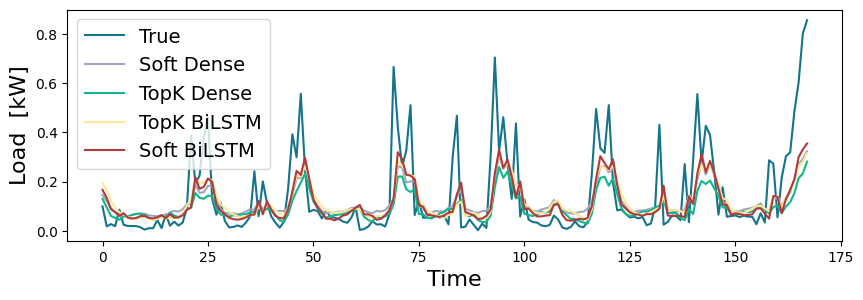

In [6]:
# Plot prediction results
start = 200
stop = start+168
fig = plt.figure(figsize=(10, 3))
plt.plot(y_load_test[user][start:stop], label='True', color='#13748B')
plt.plot(pred_load_dense_soft_model[start:stop], label='Soft Dense', color='#A0A7BC')
plt.plot(pred_load_dense_topk_model[start:stop], label='TopK Dense',color='#13B58B')
plt.plot(pred_load_bilstm_topk_model[start:stop], label='TopK BiLSTM', color='#FFE699')
plt.plot(pred_load_bilstm_soft_model[start:stop], label='Soft BiLSTM', color='#B03A3A')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Load  [kW]', fontsize=16)
plt.legend(fontsize=14)

In [7]:
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Prosumption_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index
start_date = df.index.min()
# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)
# Filter the dataframe to only include the first year of data
df = df[(df.index >= start_date) & (df.index < end_date)]

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

#Train, Validation and Test datasets
X_prosumption_train, y_prosumption_train, X_prosumption_val, y_prosumption_val, X_prosumption_test, y_prosumption_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = min_max_scaling(train_df)
    val_df = min_max_scaling(val_df)
    test_df = min_max_scaling(test_df)

    # Sequencing
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    test_sequences = create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_prosumption_train[f'user{idx+1}'], y_prosumption_train[f'user{idx+1}'] = prepare_data(train_sequences, batch_size)
    X_prosumption_val[f'user{idx+1}'], y_prosumption_val[f'user{idx+1}'] = prepare_data(val_sequences, batch_size)
    X_prosumption_test[f'user{idx+1}'], y_prosumption_test[f'user{idx+1}'] = prepare_data(test_sequences, batch_size)

dense_soft_model = tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_soft_dense_c3_FLround3.keras", compile=False, custom_objects=custom_objects)
dense_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

dense_topk_model = tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_topk_dense_c3_FLround3.keras", compile=False, custom_objects=custom_objects)
dense_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_soft_model =  tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_soft_bilstm_c3_FLround3.keras", compile=False, custom_objects=custom_objects)
bilstm_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_topk_model =  tf.keras.models.load_model(cwd + "/src/time_series/Federatedlearning/TS_FL_Grossload_Forecasting_Moe/wandb/TS_FL_Grossload_global_topk_bilstm_c3_FLround3.keras", compile=False, custom_objects=custom_objects)
bilstm_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

user = 'user1'
pred_prosumption_dense_soft_model = dense_soft_model.predict(X_prosumption_test[user], batch_size=batch_size)
pred_prosumption_dense_topk_model = dense_topk_model.predict(X_prosumption_test[user], batch_size=batch_size)
pred_prosumption_bilstm_soft_model = bilstm_soft_model.predict(X_prosumption_test[user], batch_size=batch_size)
pred_prosumption_bilstm_topk_model = bilstm_topk_model.predict(X_prosumption_test[user], batch_size=batch_size)

53/53 [==============================] - 0s 2ms/step


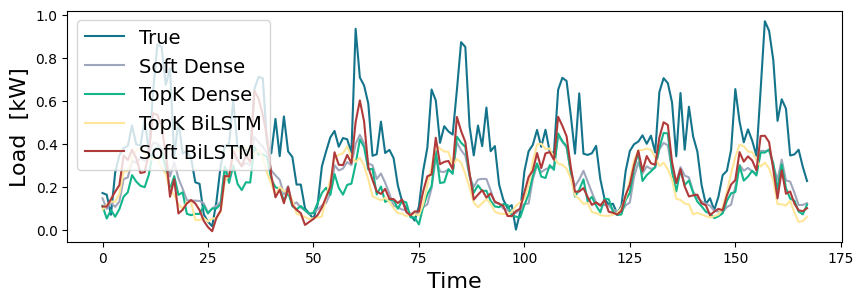

In [8]:
# Plot prediction results
start = 600
stop = start+168
fig = plt.figure(figsize=(10, 3))
plt.plot(y_prosumption_test[user][start:stop], label='True', color='#13748B')
plt.plot(pred_prosumption_dense_soft_model[start:stop], label='Soft Dense', color='#A0A7BC')
plt.plot(pred_prosumption_dense_topk_model[start:stop], label='TopK Dense',color='#13B58B')
plt.plot(pred_prosumption_bilstm_topk_model[start:stop], label='TopK BiLSTM', color='#FFE699')
plt.plot(pred_prosumption_bilstm_soft_model[start:stop], label='Soft BiLSTM', color='#B03A3A')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Load  [kW]', fontsize=16)
plt.legend(fontsize=14, loc='upper left')

In [9]:
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_PV_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index
start_date = df.index.min()
# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)
# Filter the dataframe to only include the first year of data
df = df[(df.index >= start_date) & (df.index < end_date)]

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

#Train, Validation and Test datasets
X_pv_train, y_pv_train, X_pv_val, y_pv_val, X_pv_test, y_pv_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = min_max_scaling(train_df)
    val_df = min_max_scaling(val_df)
    test_df = min_max_scaling(test_df)

    # Sequencing
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    test_sequences = create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_pv_train[f'user{idx+1}'], y_pv_train[f'user{idx+1}'] = prepare_data(train_sequences, batch_size)
    X_pv_val[f'user{idx+1}'], y_pv_val[f'user{idx+1}'] = prepare_data(val_sequences, batch_size)
    X_pv_test[f'user{idx+1}'], y_pv_test[f'user{idx+1}'] = prepare_data(test_sequences, batch_size)


dense_soft_model = tf.keras.models.load_model(cwd + "/src/time_series/Locallearning/TS_LL_PV_Forecasting_Moe/wandb/TS_LL_PV_dense_soft_moe_u10_rd1.keras", compile=False, custom_objects=custom_objects)
dense_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

dense_topk_model = tf.keras.models.load_model(cwd + "/src/time_series/Locallearning/TS_LL_PV_Forecasting_Moe/wandb/TS_LL_PV_dense_topk_moe_u10_rd1.keras", compile=False, custom_objects=custom_objects)
dense_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_soft_model =  tf.keras.models.load_model(cwd + "/src/time_series/Locallearning/TS_LL_PV_Forecasting_Moe/wandb/TS_LL_PV_lstm_soft_moe_u10_rd1.keras", compile=False, custom_objects=custom_objects)
bilstm_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_topk_model =  tf.keras.models.load_model(cwd + "/src/time_series/Locallearning/TS_LL_PV_Forecasting_Moe/wandb/TS_LL_PV_lstm_topk_moe_u10_rd1.keras", compile=False, custom_objects=custom_objects)
bilstm_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

user = 'user10'
pred_pv_dense_soft_model = dense_soft_model.predict(X_pv_test[user], batch_size=batch_size)
pred_pv_dense_topk_model = dense_topk_model.predict(X_pv_test[user], batch_size=batch_size)
pred_pv_bilstm_soft_model = bilstm_soft_model.predict(X_pv_test[user], batch_size=batch_size)
pred_pv_bilstm_topk_model = bilstm_topk_model.predict(X_pv_test[user], batch_size=batch_size)

53/53 [==============================] - 0s 2ms/step


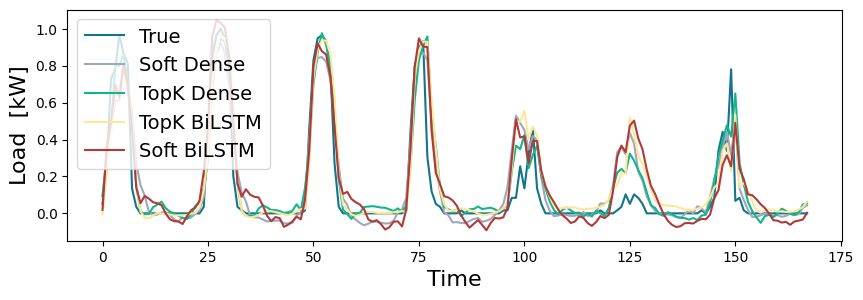

In [10]:
# Plot prediction results
start = 260
stop = start+168
fig = plt.figure(figsize=(10, 3))
plt.plot(y_pv_test[user][start:stop], label='True', color='#13748B')
plt.plot(pred_pv_dense_soft_model[start:stop], label='Soft Dense', color='#A0A7BC')
plt.plot(pred_pv_dense_topk_model[start:stop], label='TopK Dense',color='#13B58B')
plt.plot(pred_pv_bilstm_topk_model[start:stop], label='TopK BiLSTM', color='#FFE699')
plt.plot(pred_pv_bilstm_soft_model[start:stop], label='Soft BiLSTM', color='#B03A3A')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Load  [kW]', fontsize=16)
plt.legend(fontsize=14, loc='upper left')

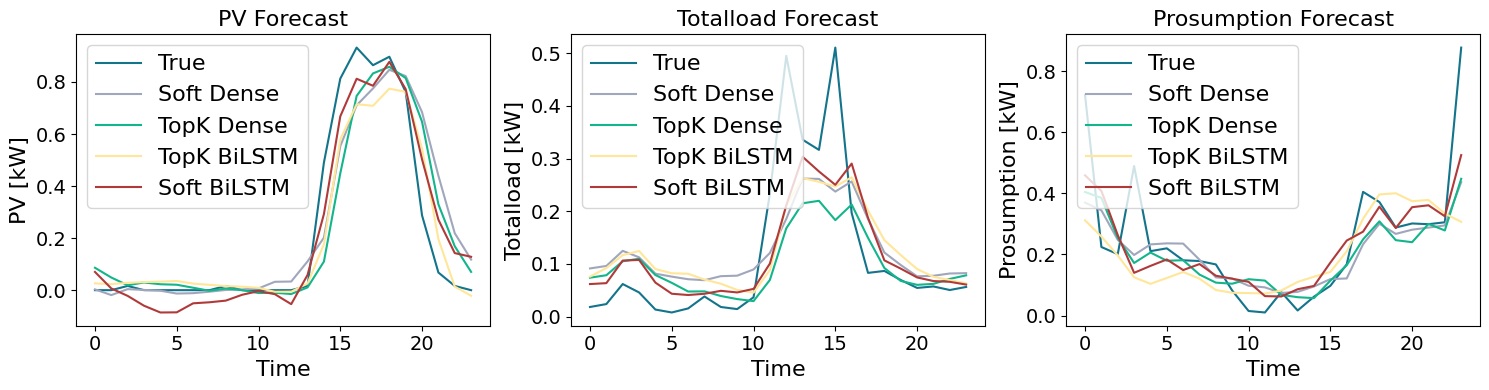

In [11]:

# Define the start and stop indices for the plots
start_pv = 199
stop_pv = start_pv + 24

start_load = 305
stop_load = start_load + 24

start_pro = 685
stop_pro = start_pro + 24

fontsize=16
# Create a figure with 1 row and 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Adjusted to 1 row, 3 columns

# Plot for PV Forecast
axs[0].plot(y_pv_test[user][start_pv:stop_pv], label='True', color='#13748B')
axs[0].plot(pred_pv_dense_soft_model[start_pv:stop_pv], label='Soft Dense', color='#A0A7BC')
axs[0].plot(pred_pv_dense_topk_model[start_pv:stop_pv], label='TopK Dense',color='#13B58B')
axs[0].plot(pred_pv_bilstm_topk_model[start_pv:stop_pv], label='TopK BiLSTM', color='#FFE699')
axs[0].plot(pred_pv_bilstm_soft_model[start_pv:stop_pv], label='Soft BiLSTM', color='#B03A3A')
# ... other PV model predictions ...
axs[0].set_title('PV Forecast', fontsize=fontsize)
axs[0].set_xlabel('Time', fontsize=fontsize)
axs[0].set_ylabel('PV [kW]', fontsize=fontsize)
axs[0].legend(loc='upper left', fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=14)

# Plot for Gross Load Forecast
axs[1].plot(y_load_test[user][start_load:stop_load], label='True', color='#13748B')
axs[1].plot(pred_load_dense_soft_model[start_load:stop_load], label='Soft Dense', color='#A0A7BC')
axs[1].plot(pred_load_dense_topk_model[start_load:stop_load], label='TopK Dense',color='#13B58B')
axs[1].plot(pred_load_bilstm_topk_model[start_load:stop_load], label='TopK BiLSTM', color='#FFE699')
axs[1].plot(pred_load_bilstm_soft_model[start_load:stop_load], label='Soft BiLSTM', color='#B03A3A')

# ... other Gross Load model predictions ...
axs[1].set_title('Totalload Forecast', fontsize=fontsize)
axs[1].set_xlabel('Time', fontsize=fontsize)
axs[1].set_ylabel('Totalload [kW]', fontsize=fontsize)
axs[1].legend(loc='upper left', fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=14)

# Plot for Other Forecast
axs[2].plot(y_prosumption_test[user][start_pro:stop_pro], label='True', color='#13748B')
axs[2].plot(pred_prosumption_dense_soft_model[start_pro:stop_pro], label='Soft Dense', color='#A0A7BC')
axs[2].plot(pred_prosumption_dense_topk_model[start_pro:stop_pro], label='TopK Dense',color='#13B58B')
axs[2].plot(pred_prosumption_bilstm_topk_model[start_pro:stop_pro], label='TopK BiLSTM', color='#FFE699')
axs[2].plot(pred_prosumption_bilstm_soft_model[start_pro:stop_pro], label='Soft BiLSTM', color='#B03A3A')
# ... other model predictions for the third forecast ...
axs[2].set_title('Prosumption Forecast', fontsize=fontsize)
axs[2].set_xlabel('Time', fontsize=fontsize)
axs[2].set_ylabel('Prosumption [kW]', fontsize=fontsize)
axs[2].legend(loc='upper left', fontsize=fontsize)
axs[2].tick_params(axis='both', which='major', labelsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

# 1. Cluster wise results

In [12]:
y = np.loadtxt(f'../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=',').astype(int)
num_clusters = 10
cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 7, 14, 18, 22, 23, 25, 29], dtype=int64),
 1: array([6], dtype=int64),
 2: array([ 3,  4,  9, 13, 15, 19, 20, 30], dtype=int64),
 3: array([1], dtype=int64),
 4: array([21], dtype=int64),
 5: array([ 2, 28], dtype=int64),
 6: array([ 5, 10, 11, 12, 24, 26, 27], dtype=int64),
 7: array([8], dtype=int64),
 8: array([17], dtype=int64),
 9: array([16], dtype=int64)}

### Show result dataframe

In [13]:
def get_rmse_df_clusterwise(df, cluster_users, scenario, cluster_id, metric='rmse'):
    # Filter DataFrame for users in the cluster
    df_cluster = df[df['user'].isin(cluster_users)]

    # Calculate mean and standard deviation for the specified metric
    rmse_stats = df_cluster.groupby('architecture')[metric].agg(['mean', 'std']).reset_index()

    # Add model_type and cluster columns
    rmse_stats['model_type'] = scenario
    rmse_stats['cluster'] = cluster_id

    return rmse_stats


# Load and process all DataFrames
cwd = os.path.normpath(os.path.dirname(os.getcwd()))

all_results = []
for cluster_id, users in cluster_users.items():
    user_identifiers = ['user' + str(user_id) for user_id in users]
    for category, paths in file_paths.items():
        learning_type = 'Federated' if 'FL' in category else 'Local'
        for path in paths:
            df = load_csv(cwd +'/'+ path)
            # Extract model type from file path
            model_type = path.split('/')[-1].split('_')[1]
            full_scenario = f"{learning_type}_{model_type}_{category.split('_')[-1]}"
            processed_df = get_rmse_df_clusterwise(df, user_identifiers, full_scenario, cluster_id, metric='rmse')
            all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)

model_name_mapping = {
    'global_bilstm': 'Lstm',
    'global_cnn': 'Cnn',
    'global_transformer': 'Transformer',
    'global_soft_bilstm': 'Soft_Lstm',
    'global_topk_bilstm': 'Topk_Lstm',
    'global_soft_dense': 'Soft_Dense',
    'global_topk_dense': 'Topk_Dense',
    'bilstm': 'Lstm',
    'cnn': 'Cnn',
    'transformer': 'Transformer',
    'lstm_soft_moe': 'Soft_Lstm',
    'lstm_topk_moe': 'Topk_Lstm',
    'dense_soft_moe': 'Soft_Dense',
    'dense_topk_moe': 'Topk_Dense'
}
combined_average_metrics['model'] = combined_average_metrics['architecture'].map(model_name_mapping)

# Drop the 'architecture' column
combined_average_metrics.drop(columns=['architecture'], inplace=True)

# Split the 'model_type' column into 'learning' and 'data' columns
combined_average_metrics[['learning', 'data']] = combined_average_metrics['model_type'].str.rsplit('_', n=1, expand=True)

# Extract only 'Federated' from the 'learning' column
combined_average_metrics['learning'] = combined_average_metrics['learning'].str.split('_').str[0]

# Now, you can drop the 'model_type' column if it's no longer needed
combined_average_metrics.drop(columns=['model_type'], inplace=True)

agg_results = combined_average_metrics.groupby(['data', 'learning', 'model']).agg({
    'mean': ['mean'],
    'std': ['mean']
}).reset_index()

In [14]:
# Filter the DataFrame for 'Grossload' data
filtered_results = agg_results[(agg_results['data'] == 'PV')]

# Create a custom order for the models
custom_order = ['Lstm', 'Cnn', 'Transformer', 'Soft_Dense', 'Topk_Dense', 'Soft_Lstm', 'Topk_Lstm']

# Pivot the DataFrame to reshape it
reshaped_results = filtered_results.pivot(index='model', columns='learning', values=['mean', 'std'])

# Rename the columns for clarity
reshaped_results.columns = [f'{col[0]} {col[1]}' for col in reshaped_results.columns]

# Reorder the rows based on the custom order
reshaped_results = reshaped_results.loc[custom_order]

# Reorder the columns
reshaped_results = reshaped_results[['mean Local', 'std Local', 'mean Federated', 'std Federated']]
reshaped_results = reshaped_results.round(4)

reshaped_results

mean Local  std Local  mean Federated  std Federated
model                                                            
Lstm             0.1079     0.0109          0.1074         0.0086
Cnn              0.2489     0.0098          0.2489         0.0098
Transformer      0.2161     0.0493          0.2429         0.0317
Soft_Dense       0.1081     0.0099          0.1077         0.0066
Topk_Dense       0.1156     0.0146          0.1131         0.0062
Soft_Lstm        0.1058     0.0078          0.1009         0.0056
Topk_Lstm        0.1099     0.0115          0.1082         0.0063

### Show result boxplots

In [15]:
# Load and process all DataFrames
all_results = []
for cluster_id, users in cluster_users.items():
    user_identifiers = ['user' + str(user_id) for user_id in users]  # Adjust based on your user naming scheme
    for category, paths in file_paths.items():
        for path in paths:
            df = load_csv(path)
            processed_df = process_dataframe_clusterwise(df, user_identifiers, category, cluster_id, metric='rmse')
            all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)
combined_average_metrics.head(5)

architecture  train_time  avg_time_epoch       min       25%  \
0       global_bilstm    6.311175        6.153505  0.101538  0.108271   
1          global_cnn    1.577113        1.475209  0.120082  0.133410   
2  global_transformer   18.430852       17.676254  0.119594  0.138940   
3  global_soft_bilstm    4.536250        4.386328  0.094032  0.104720   
4  global_topk_bilstm    4.868483        4.669335  0.097814  0.107904   

        50%       75%       max    model_type  cluster  
0  0.128837  0.142943  0.203467  FL_Grossload        0  
1  0.147750  0.199360  0.201882  FL_Grossload        0  
2  0.149510  0.187728  0.247292  FL_Grossload        0  
3  0.120570  0.128177  0.192984  FL_Grossload        0  
4  0.120574  0.128736  0.197991  FL_Grossload        0

In [16]:
def standardize_and_simplify_model_names(name):
    """
    Standardize and simplify model names.
    - Removes 'global_' prefix.
    - Removes '_moe' suffix.
    - Replaces 'bilstm' with 'lstm'.
    - Standardizes names with 'soft' or 'topk' at the beginning.
    """
    # Replace specific substrings
    name = name.replace('global_', '').replace('_moe', '').replace('bilstm', 'Lstm').replace('lstm', 'Lstm').replace('cnn', 'Cnn').replace('transformer', 'Transformer').replace('dense', 'Dense')

    # Standardize names for 'soft' and 'topk'
    name_parts = name.split('_')
    for prefix in ['soft', 'topk']:
        if prefix in name_parts:
            name_parts.remove(prefix)
            return f'{prefix.title()}_{"_".join(name_parts)}'
    return name

def get_plot_title(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']
    

model_types = ['FL_Grossload', 'LL_Grossload', 'FL_Prosumption', 'LL_Prosumption', 'FL_PV', 'LL_PV', 'FL_Totalload', 'LL_Totalload']
num_clusters = 10  # Assuming 10 clusters

C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\1151159787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\1151159787.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\1151159787.py:7: SettingWithCopyWarning: 
A value is 

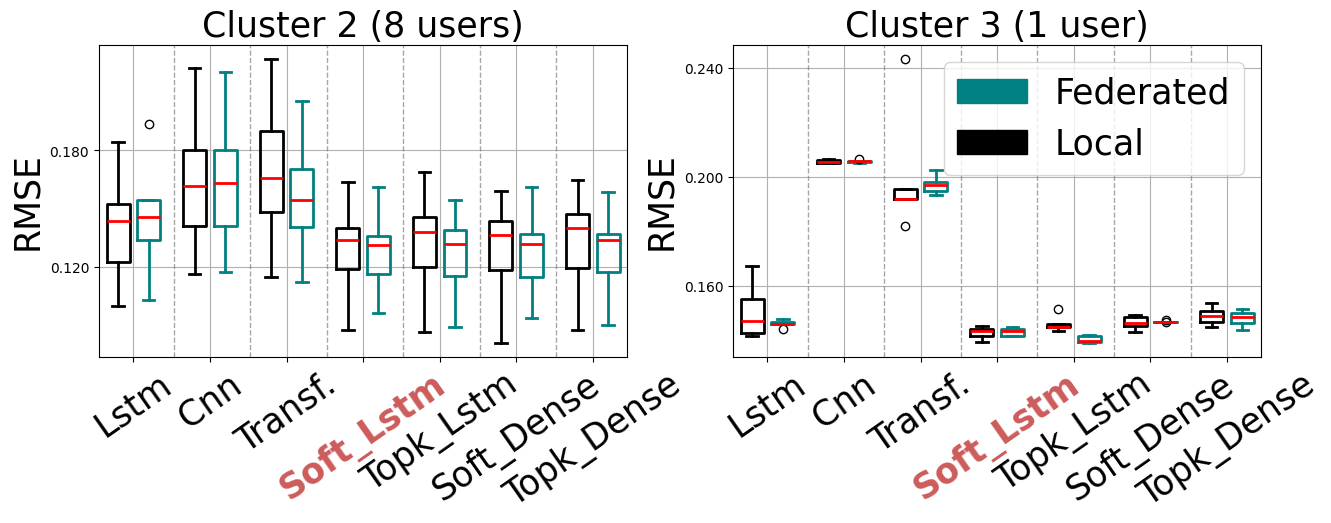

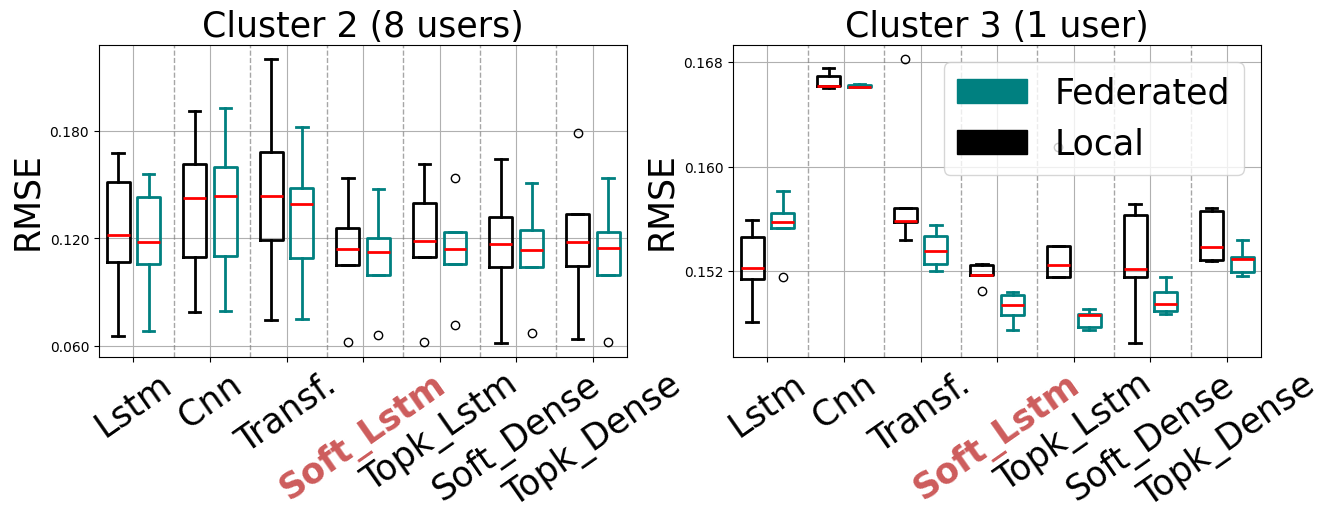

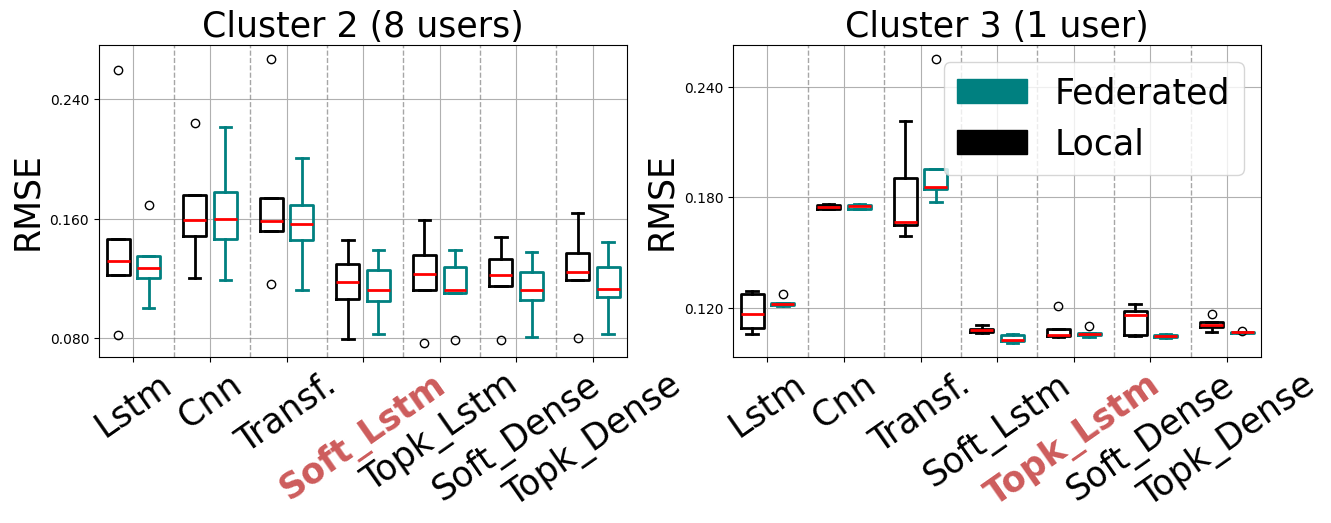

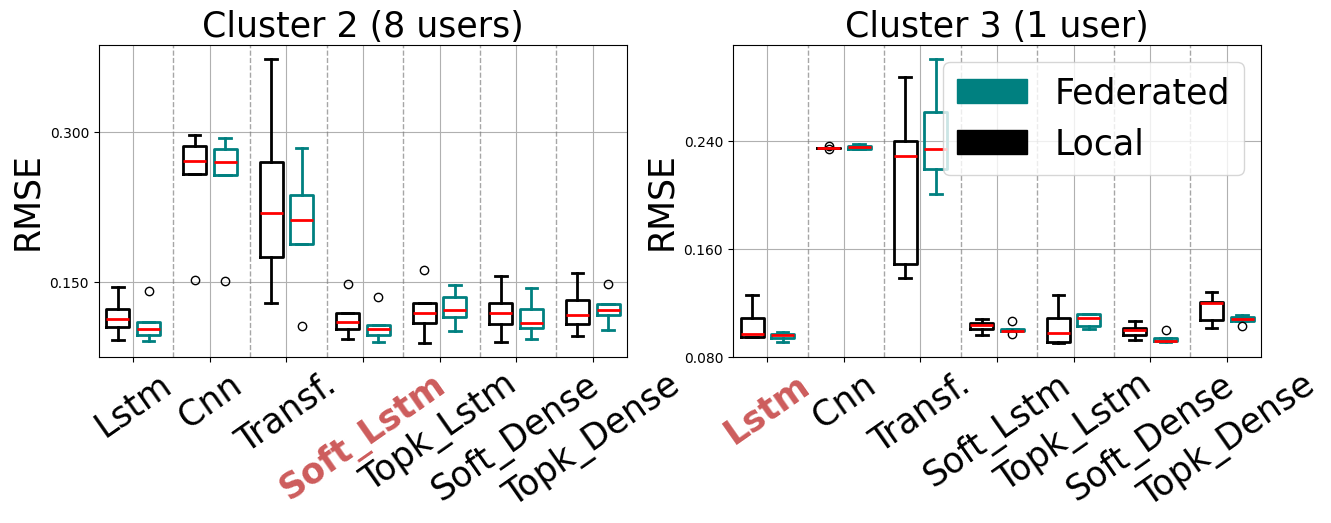

In [17]:
def plot_rmse_boxplot(df_ll, df_fl, use_case, figsize=(15, 4)):
    """
    Function to plot boxplots for RMSE values in the given DataFrames for LL and FL.
    Displays results for Cluster 3 and 2 side by side in one plot for each use case.
    """
    # Shorten model names by removing 'global_' prefix
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    fontsize = 25
    plt.figure(figsize=figsize)

    # Create subplots for Cluster 3 and 2
    for i, cluster_number in enumerate([2, 3]):
        ax = plt.subplot(1, 2, i + 1)  # Create subplot in position i+1

        cluster_data_ll = df_ll[df_ll['cluster'] == cluster_number]
        cluster_data_fl = df_fl[df_fl['cluster'] == cluster_number]

        # Extract boxplot data for LL and FL
        boxplot_data_ll = cluster_data_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
        boxplot_data_fl = cluster_data_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

        # Plot Local Learning boxplots
        boxplot_data_ll.boxplot(ax=ax, positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        # Plot Federated Learning boxplots in green
        boxplot_data_fl.boxplot(ax=ax, positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        ax.set_ylabel('RMSE', fontsize=fontsize)

        x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
        x_labels = ['Transf.' if label == 'Transformer' else label for label in boxplot_data_ll.columns]
        #x_labels = boxplot_data_ll.columns
        
        lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
        for i, label in enumerate(x_labels):
            if label == lowest_median_label:
                ax.get_xticklabels()[i].set_color("indianred")
                ax.get_xticklabels()[i].set_weight("bold")

        offset = 0
        for label in ax.get_xticklabels():
            transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
            label.set_transform(transform)

        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels, rotation=35, ha='center', fontsize=fontsize)

        for i in range(1, len(x_ticks)):
            ax.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

        # Set y-axis format
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        ax.set_title(f'Cluster {cluster_number} ({len(cluster_users[cluster_number])} {"user" if len(cluster_users[cluster_number]) == 1 else "users"})', y=1, fontsize=fontsize)

    # Global settings for the plot
    #plt.suptitle(get_plot_title(use_case), fontsize=fontsize, y=1.05)
    plt.subplots_adjust(hspace=2, top=0.89)  # Adjust spacing as needed
    teal_patch = mpatches.Patch(color='teal', label='Federated')
    black_patch = mpatches.Patch(color='black', label='Local')
    plt.legend(handles=[teal_patch, black_patch], fontsize=fontsize, loc='upper right')
    title = get_plot_title(use_case)
    plt.savefig(f'Figure10_{title}.svg', format='svg', bbox_inches='tight')
    #plt.show()


# Assuming combined_average_metrics is a DataFrame with your data
num_clusters = 10  # Assuming 10 clusters
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in ['Totalload', 'Grossload', 'Prosumption', 'PV']:
    df_ll_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'LL_{use_case}')]
    df_fl_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'FL_{use_case}')]
    plot_rmse_boxplot(df_ll_use_case, df_fl_use_case, use_case)


C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


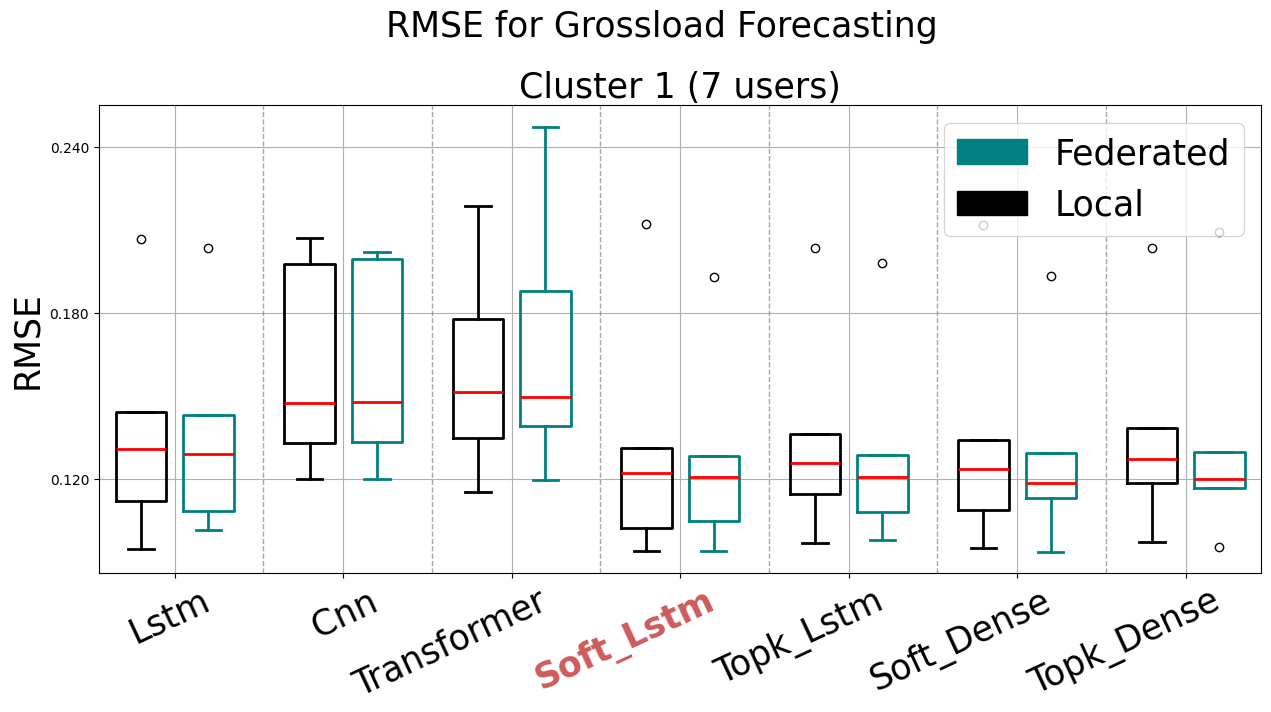

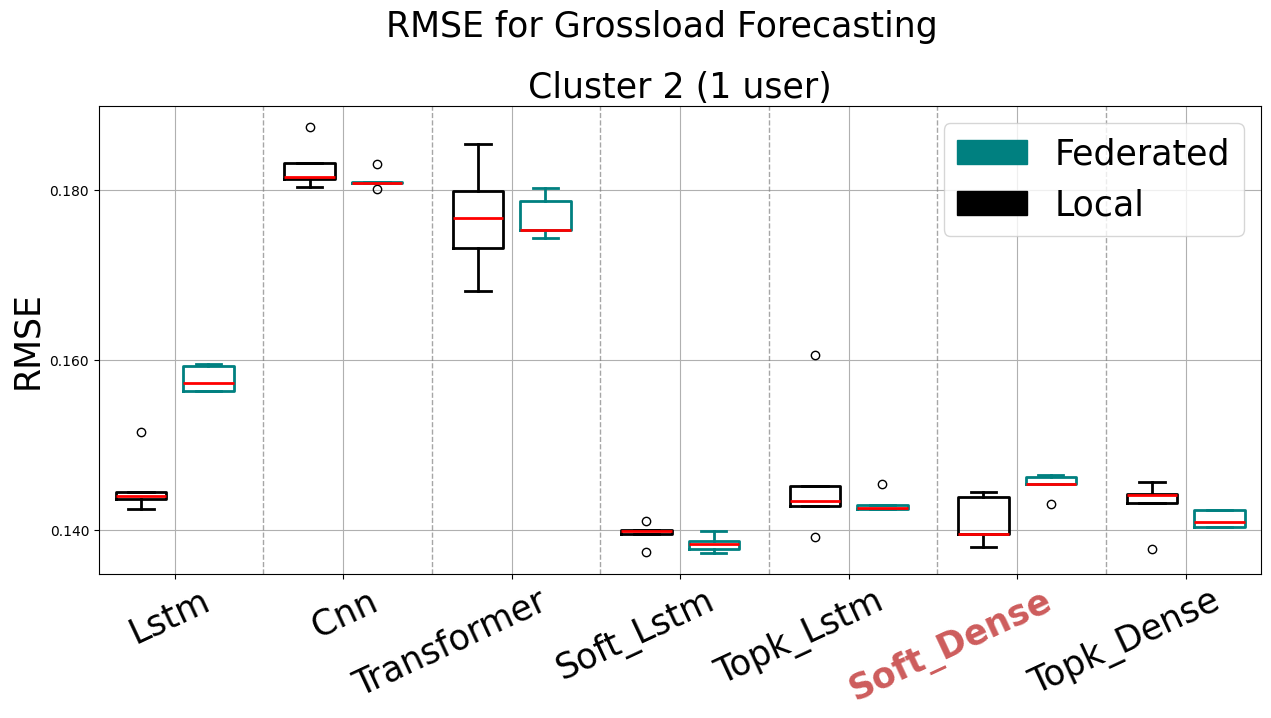

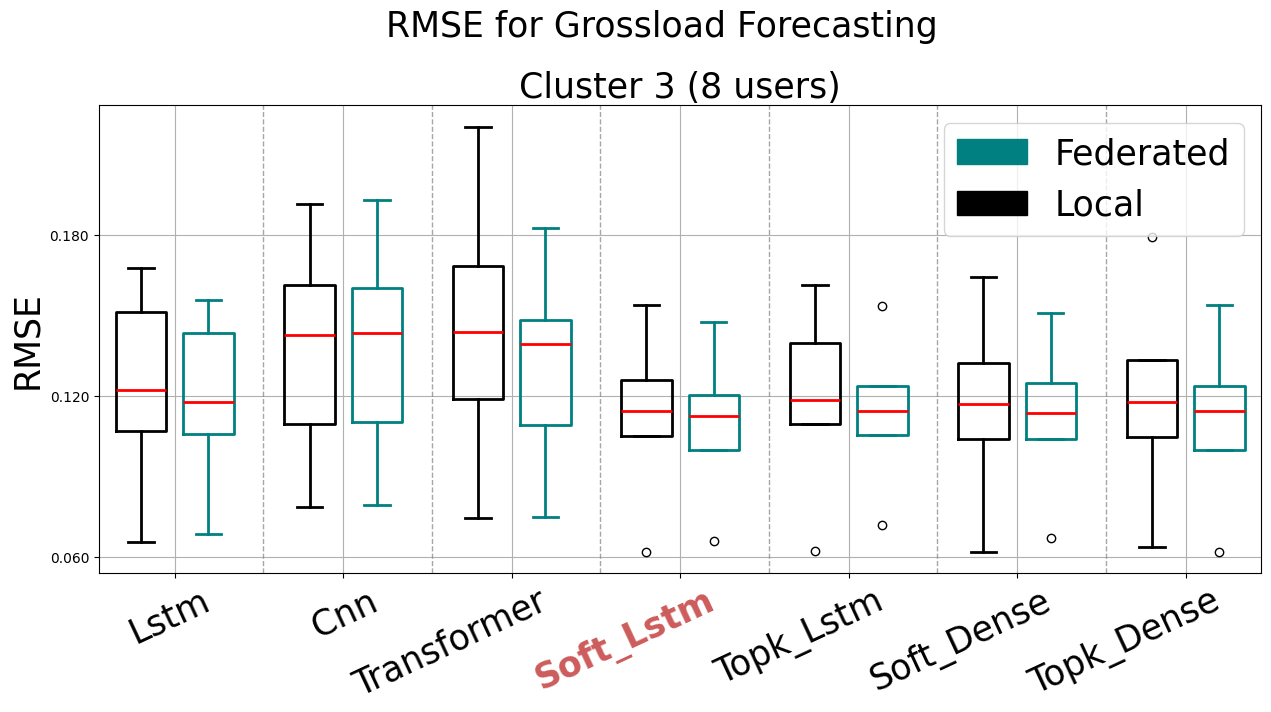

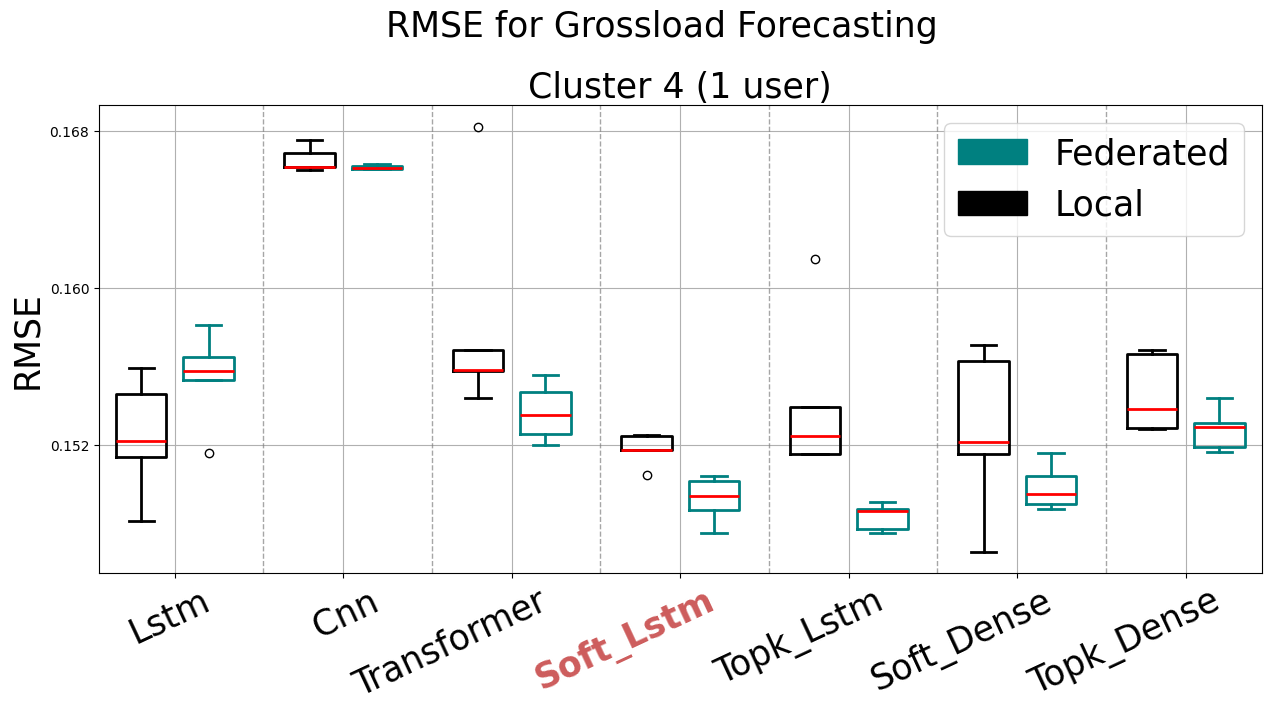

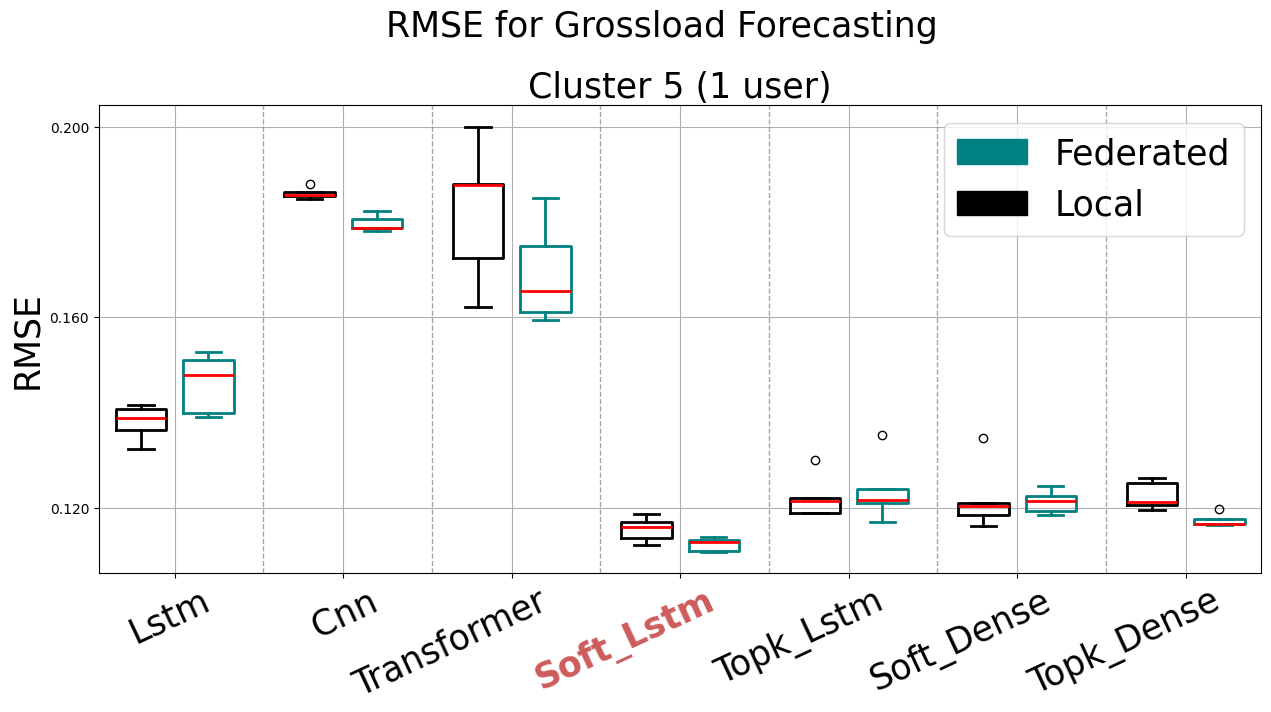

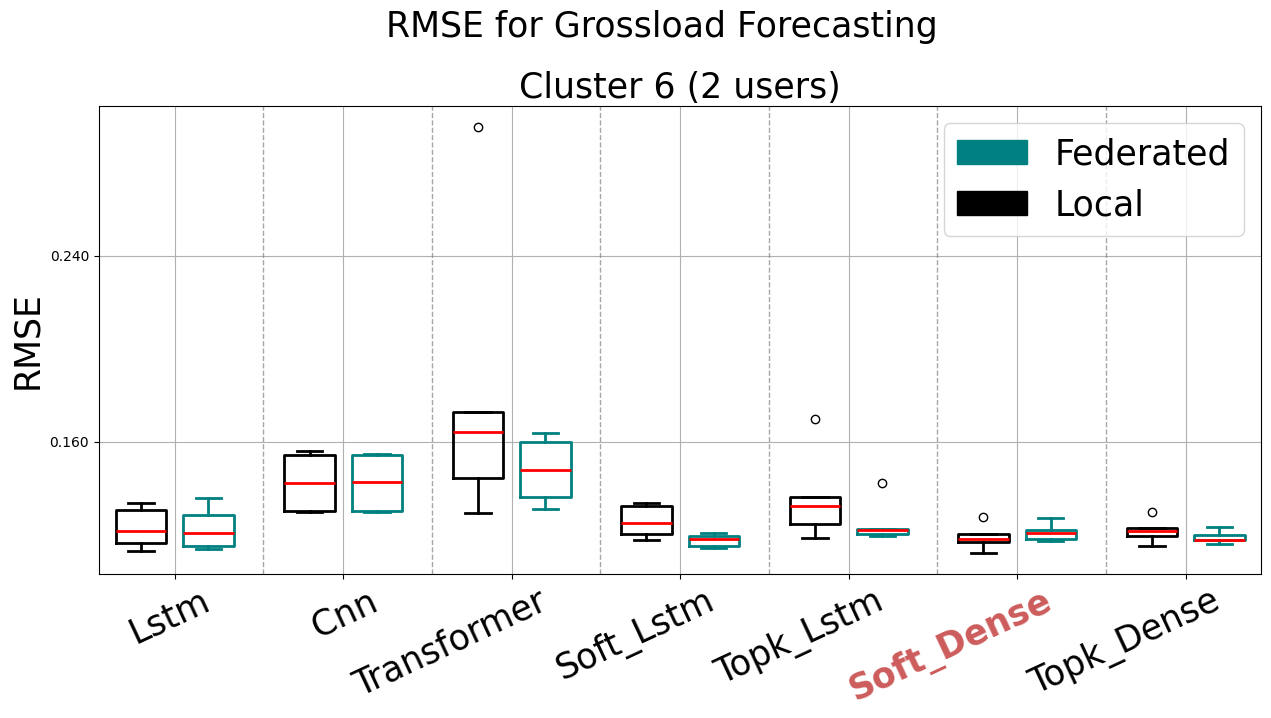

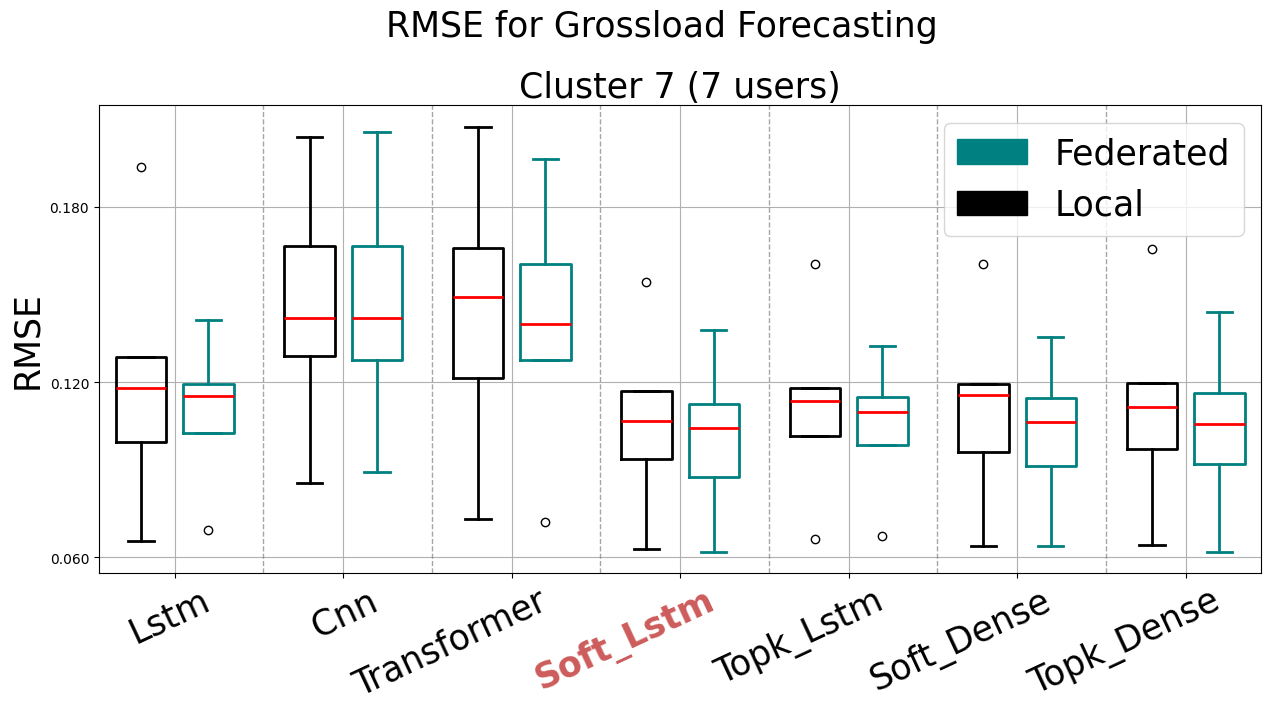

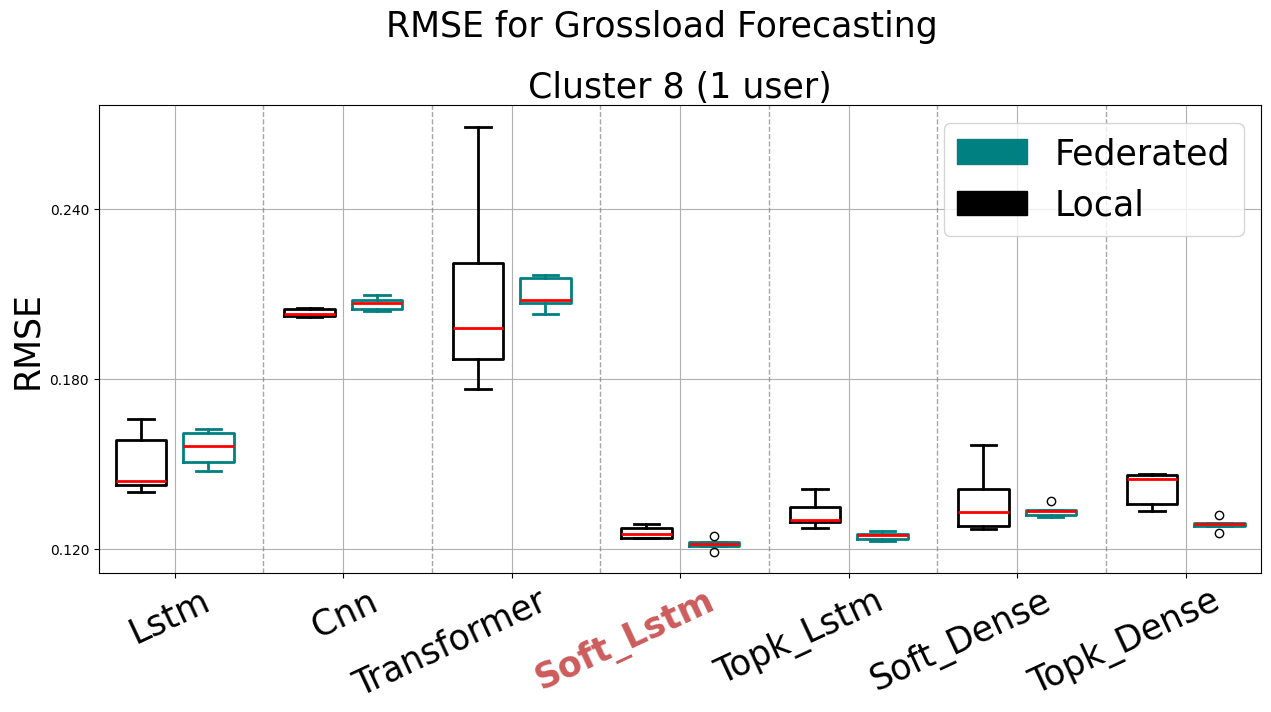

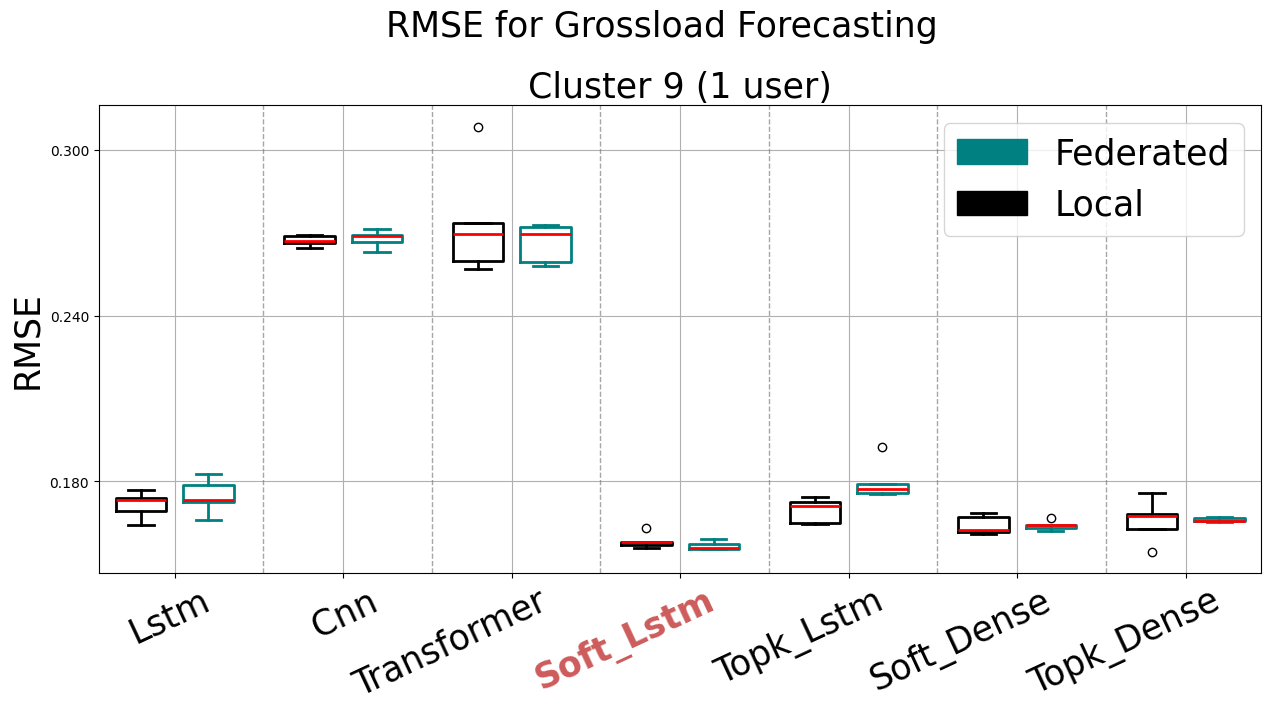

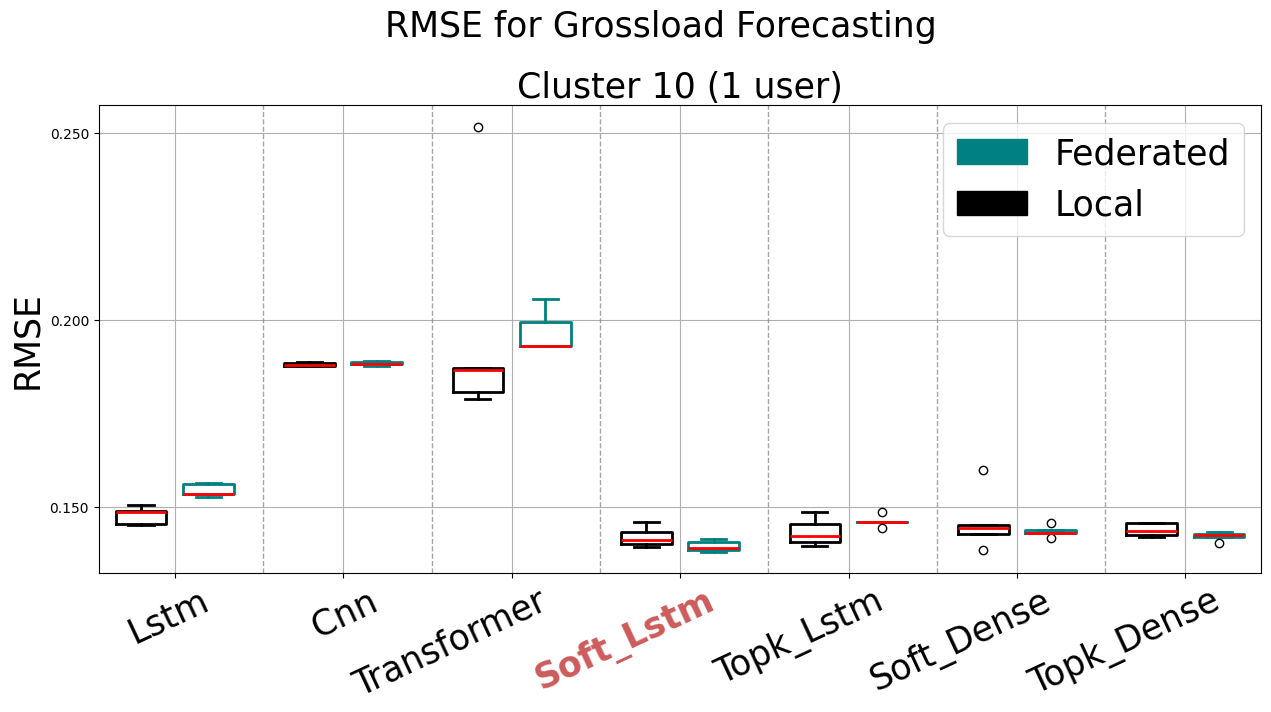

C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


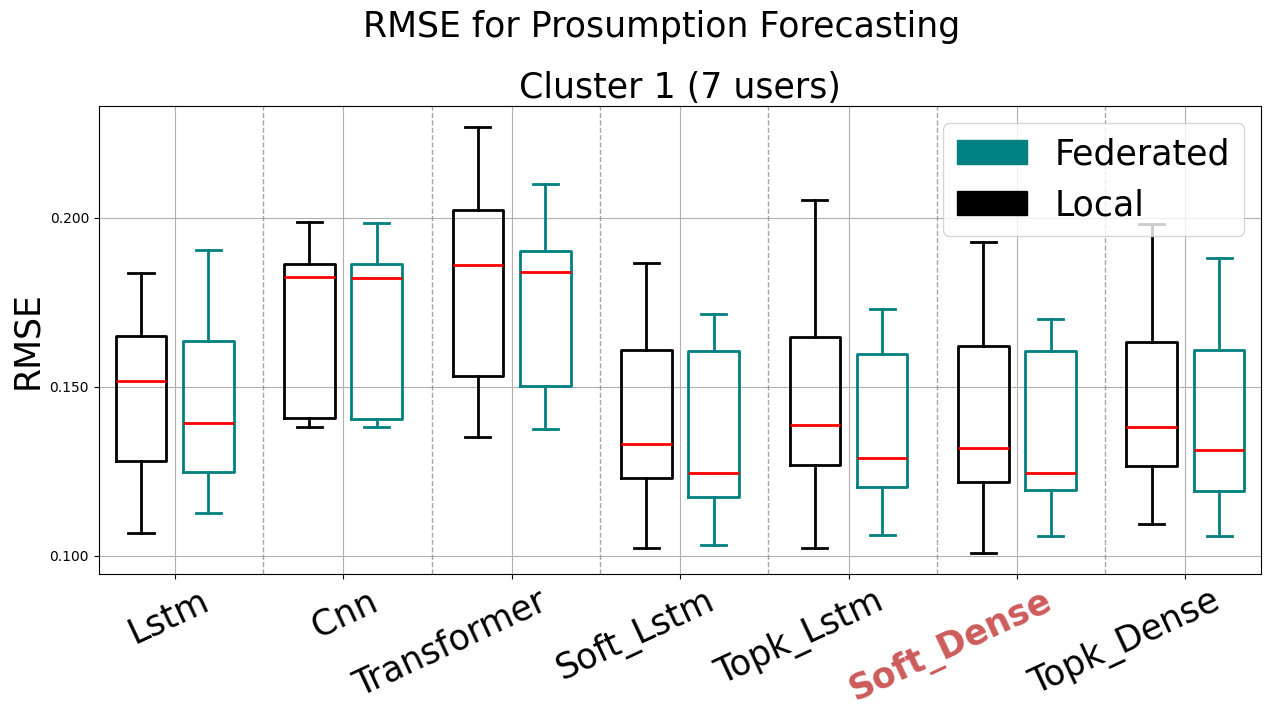

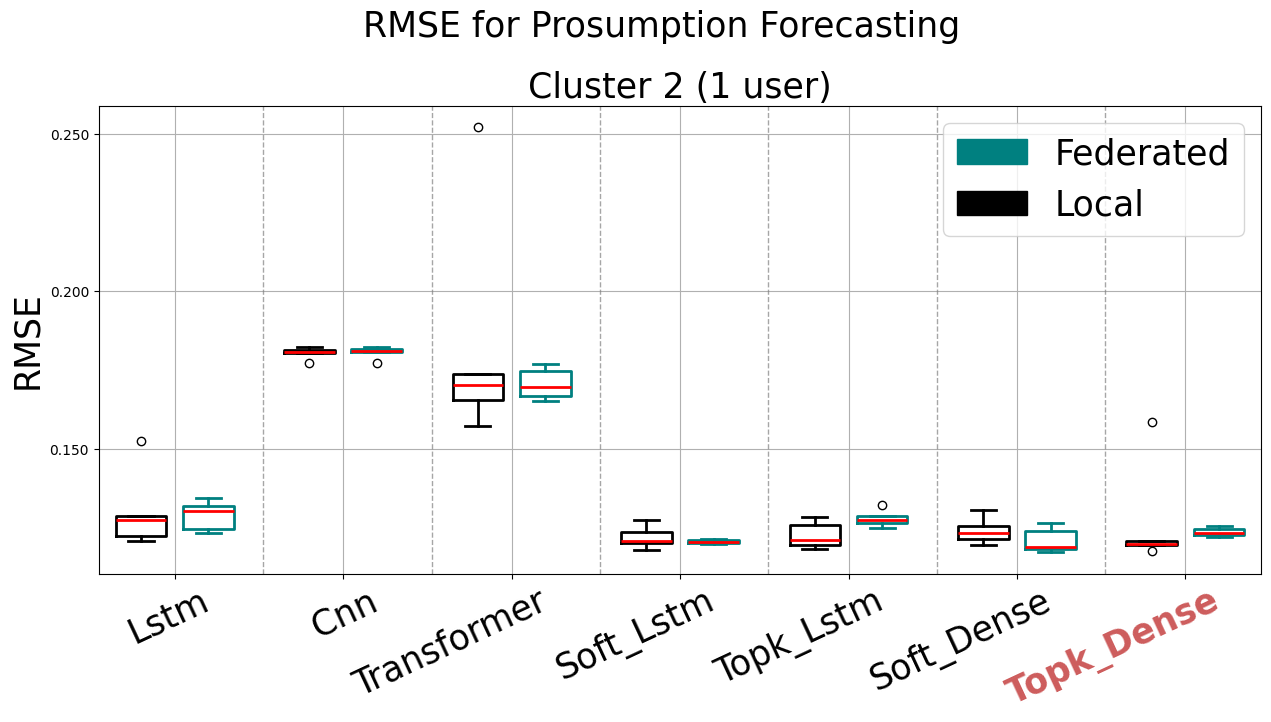

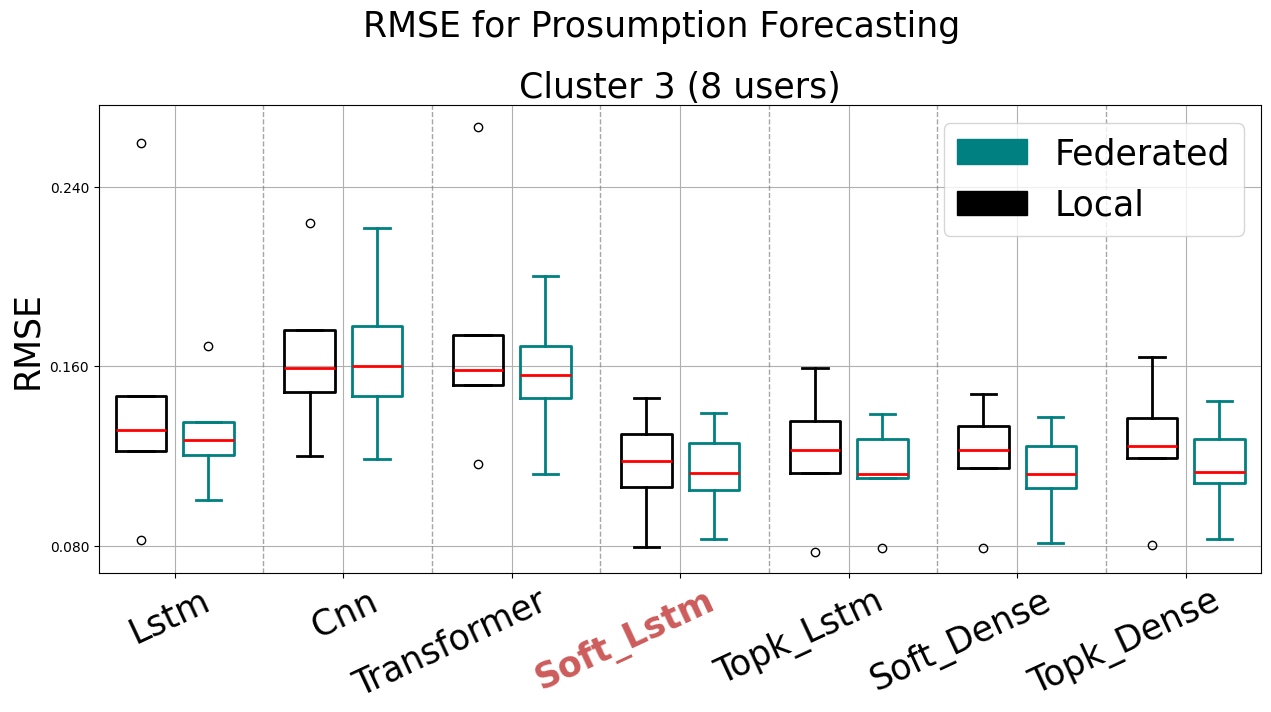

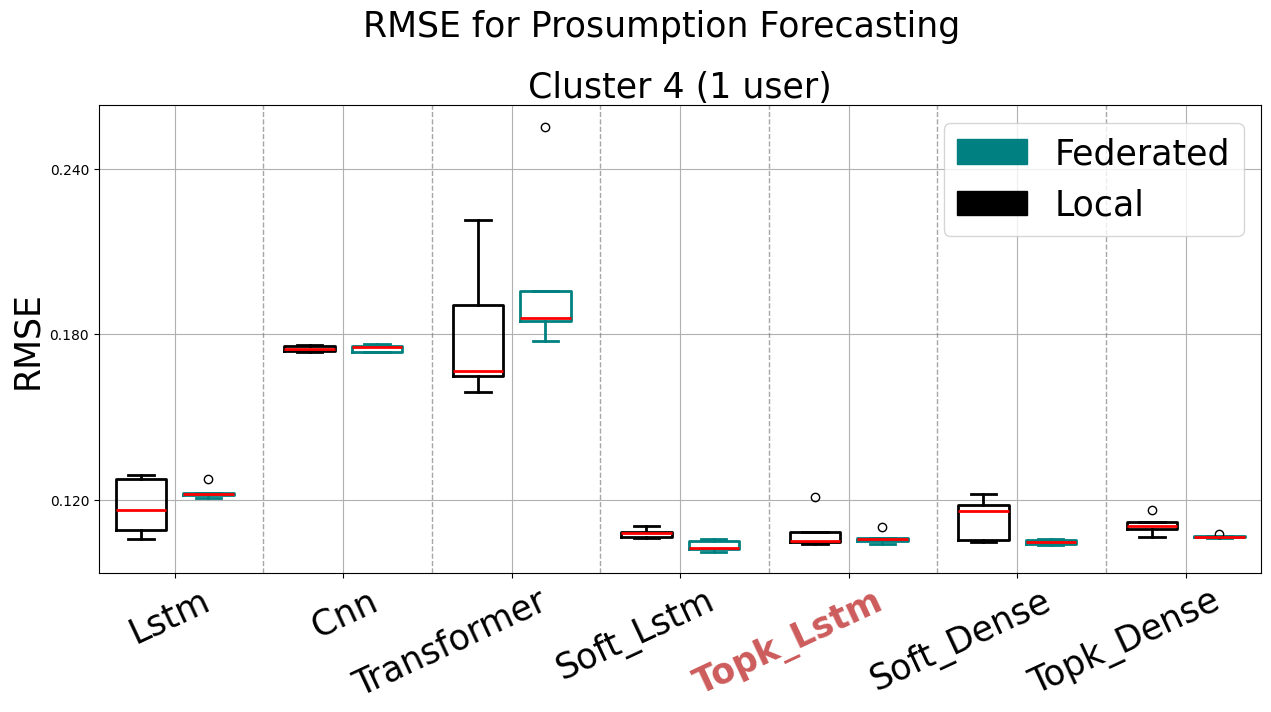

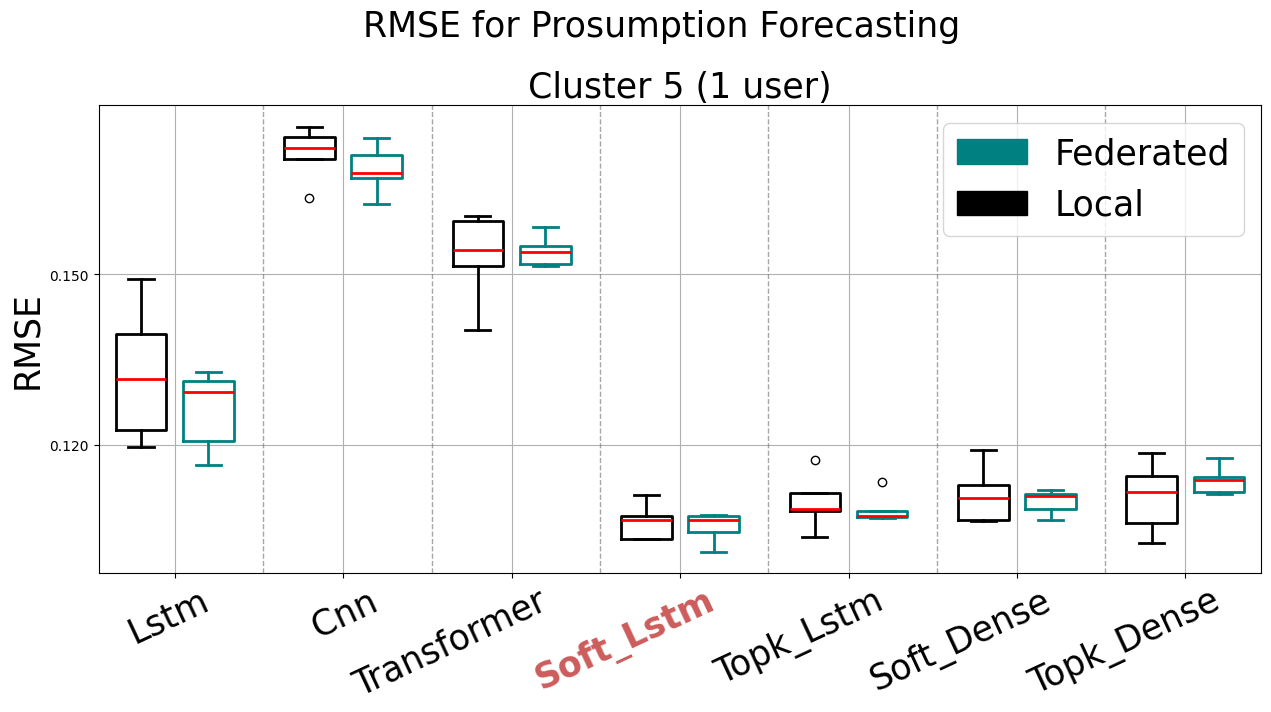

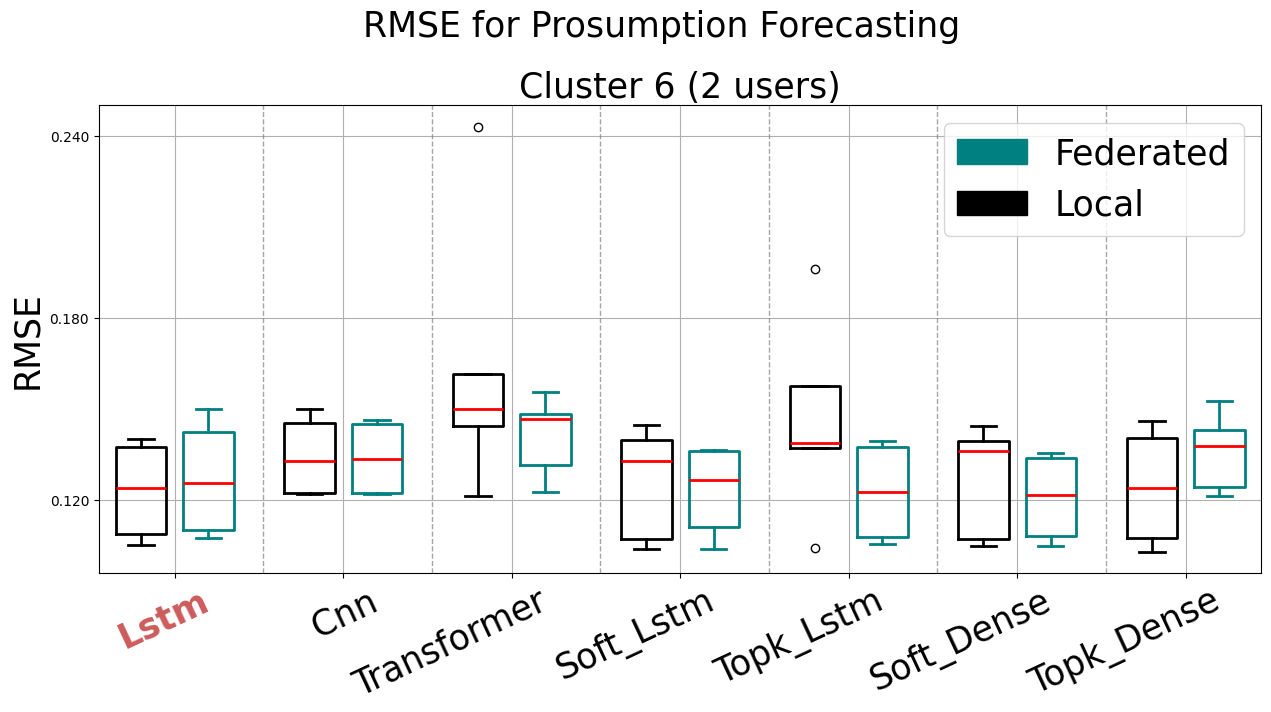

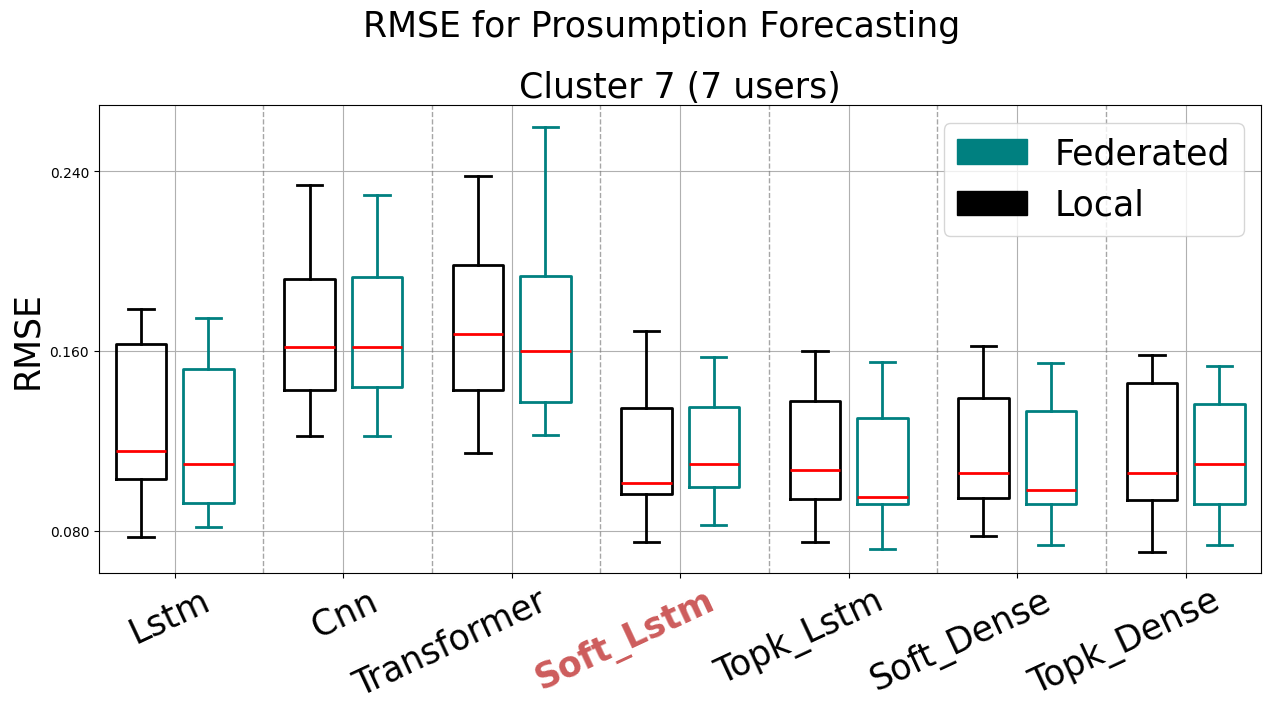

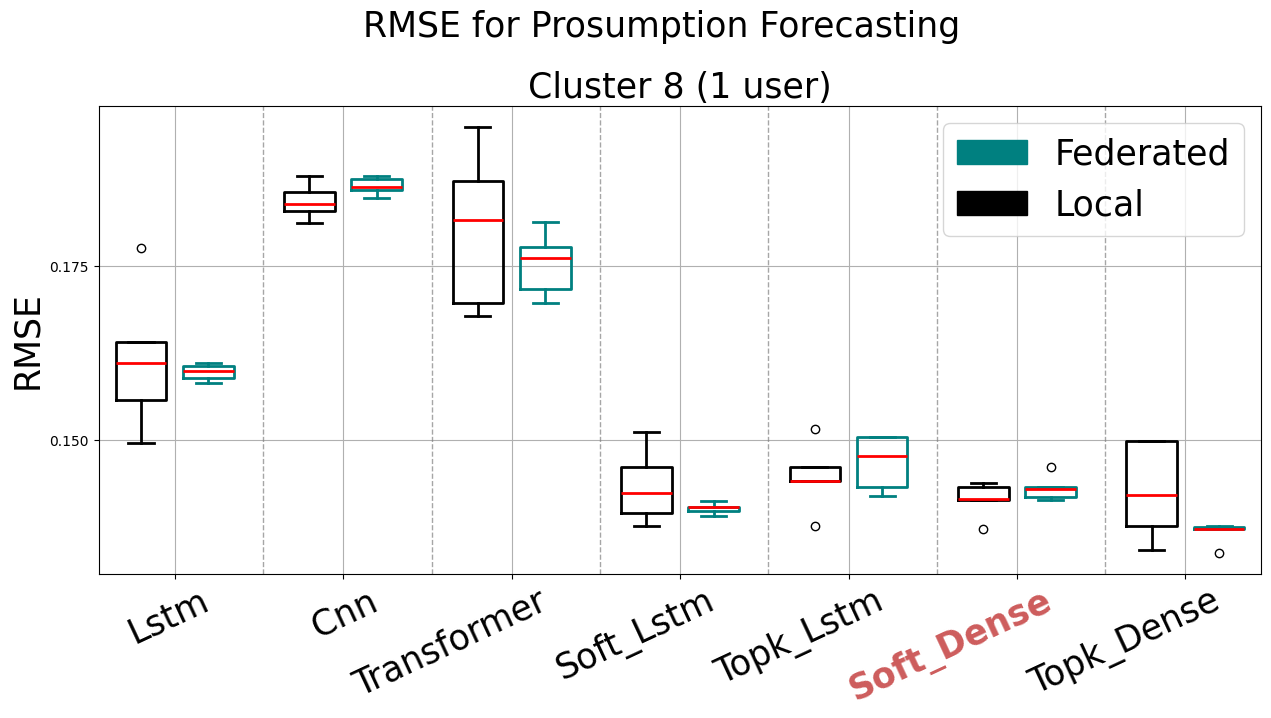

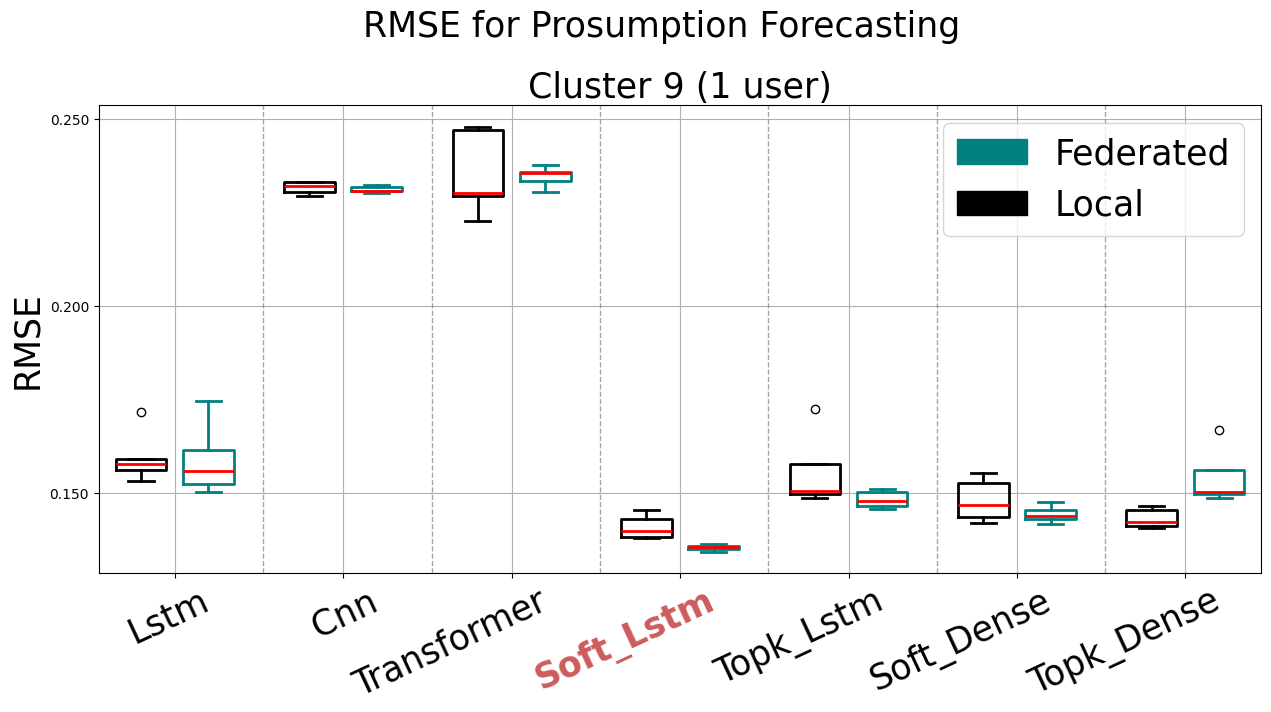

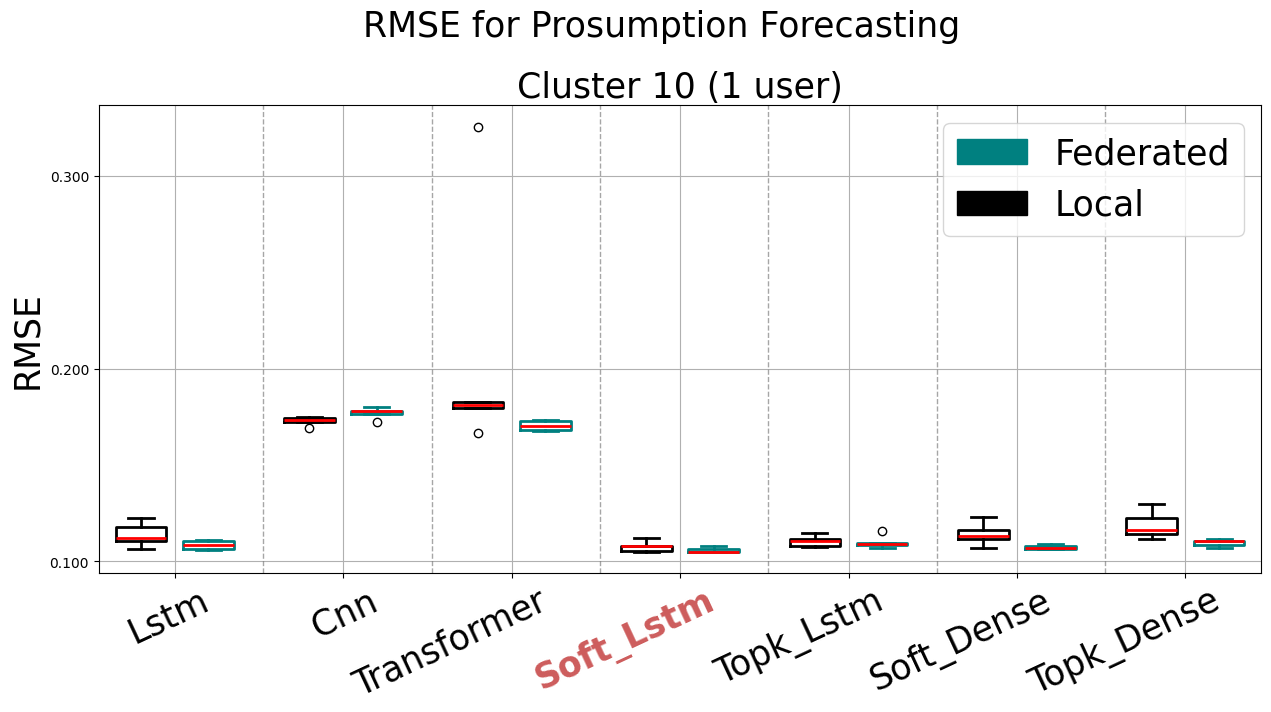

C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


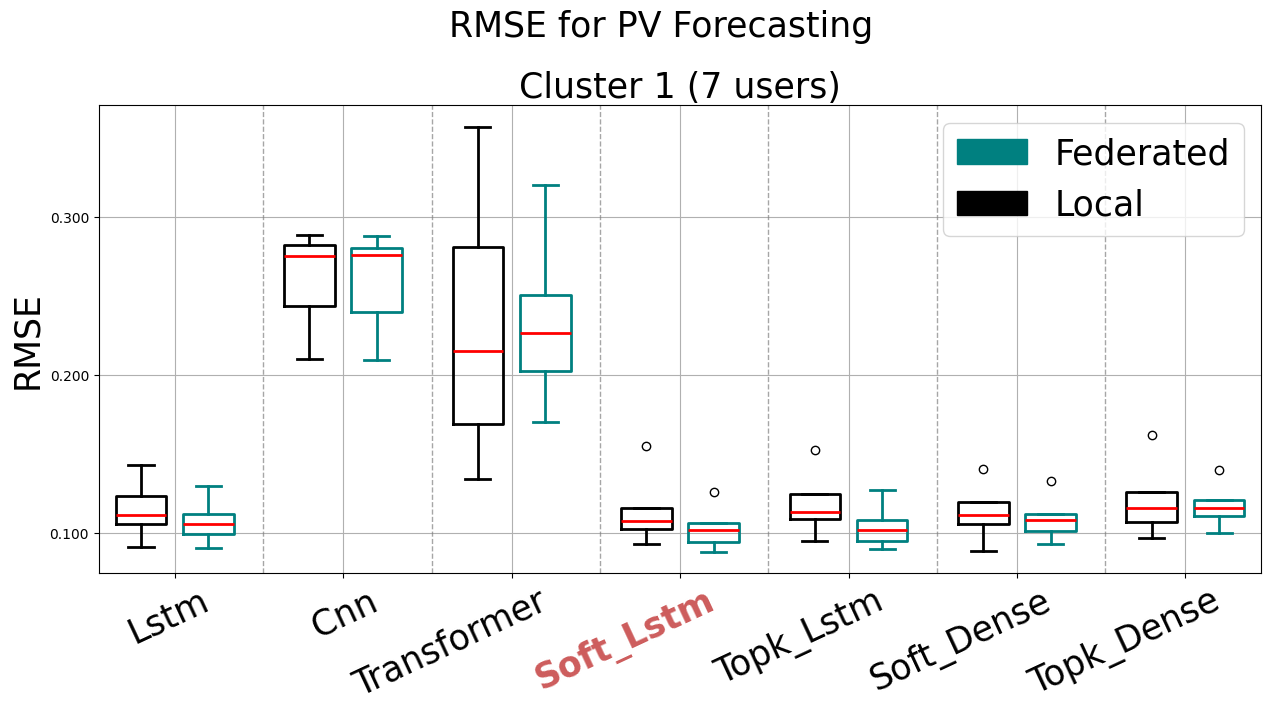

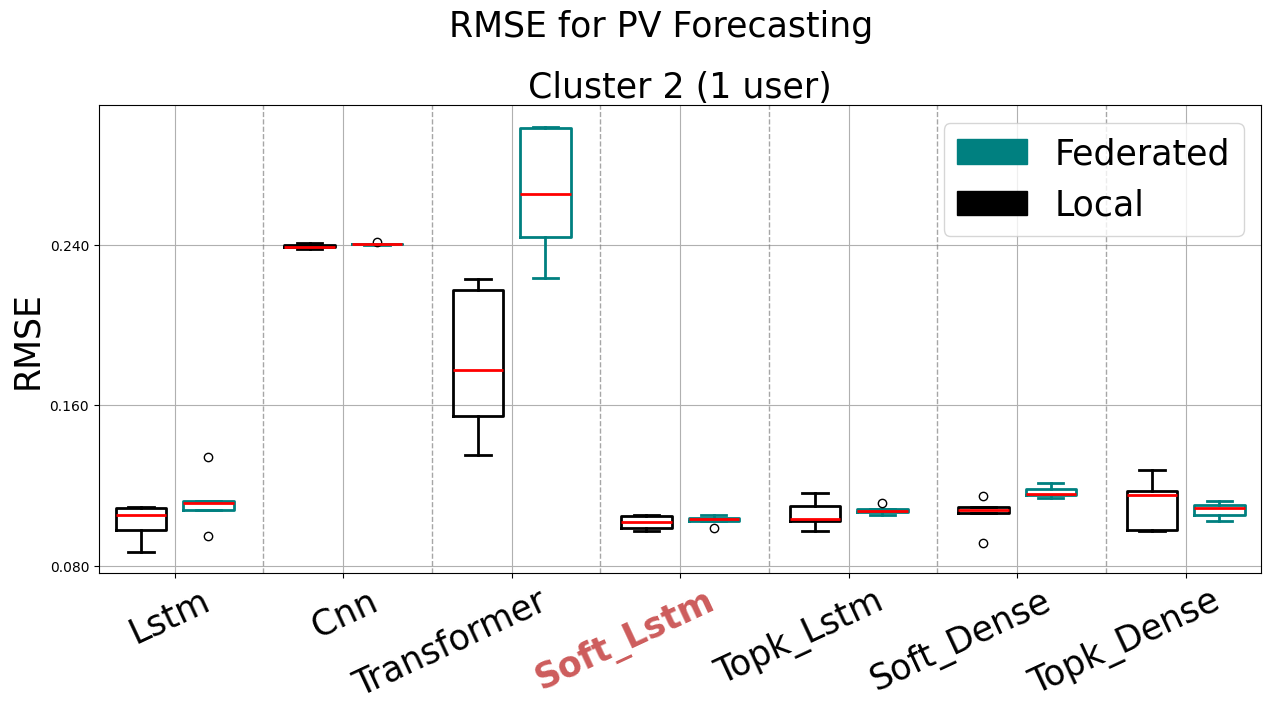

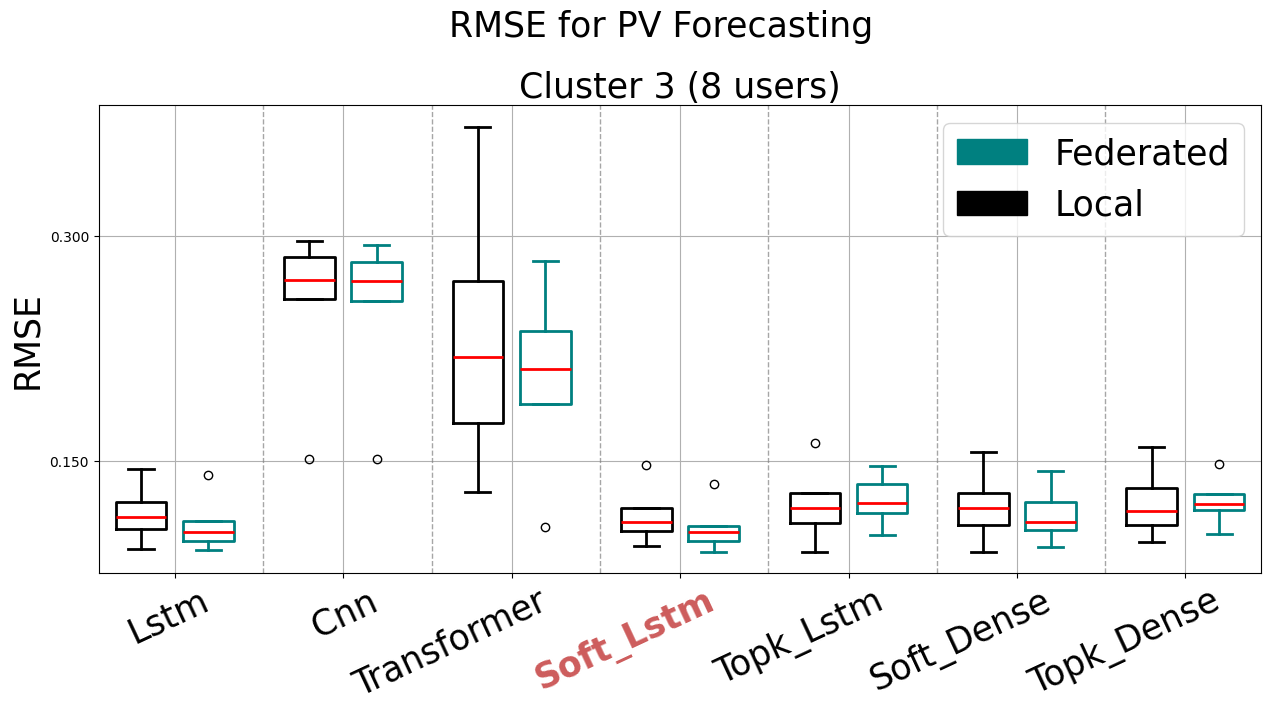

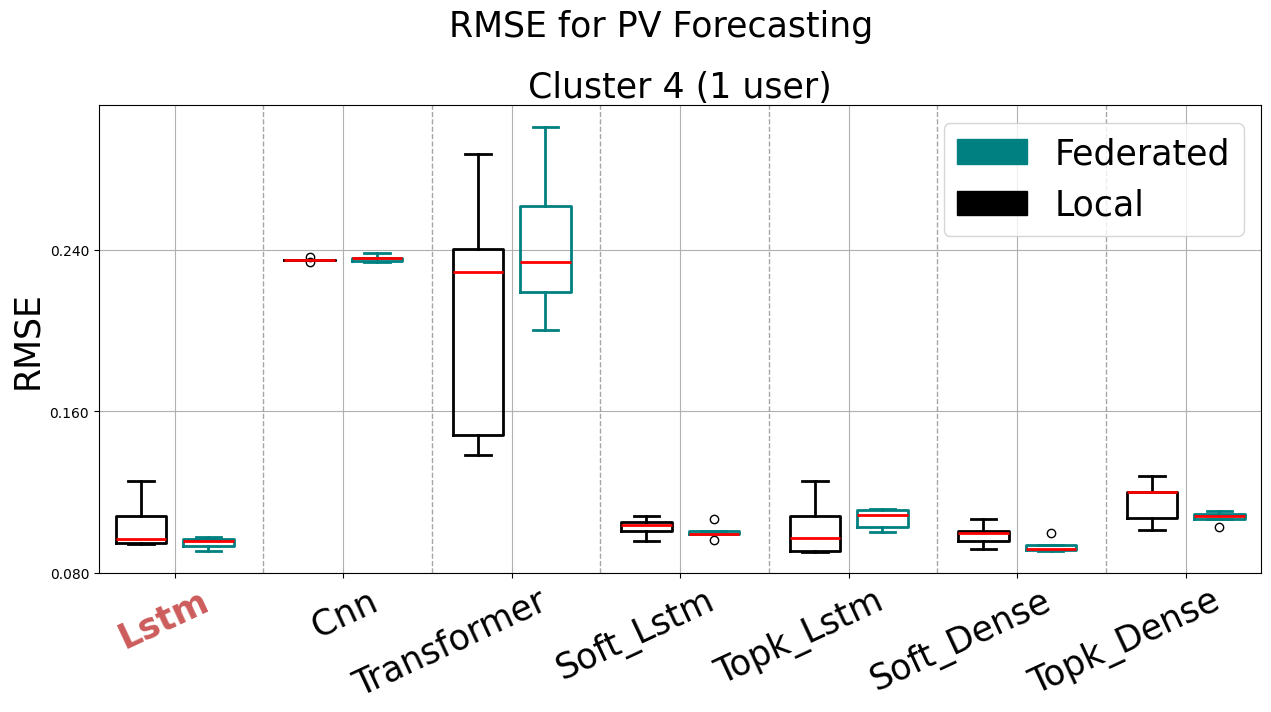

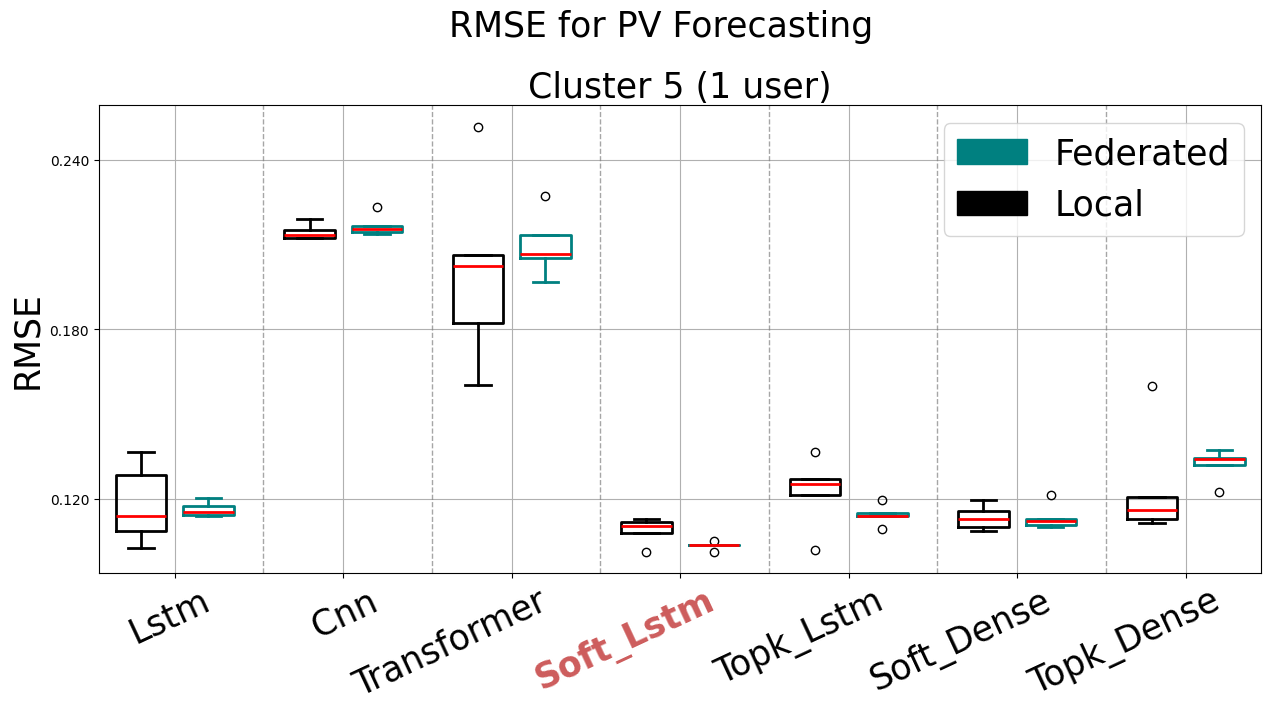

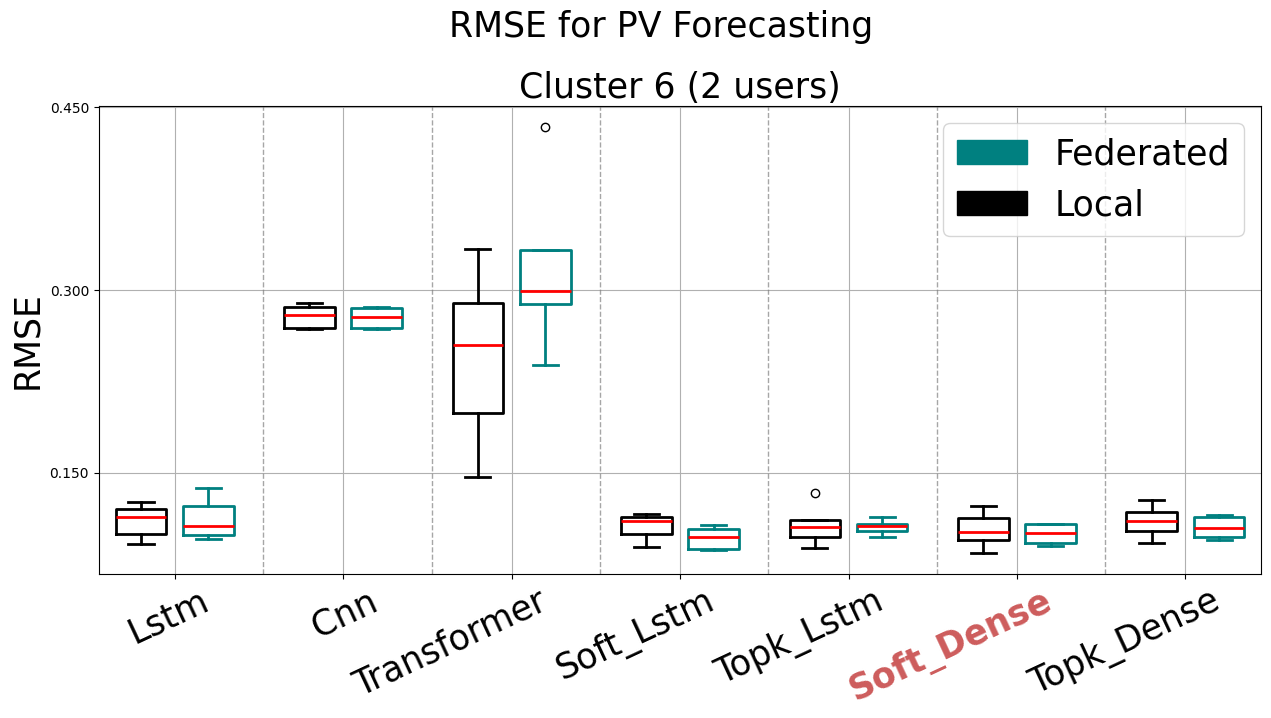

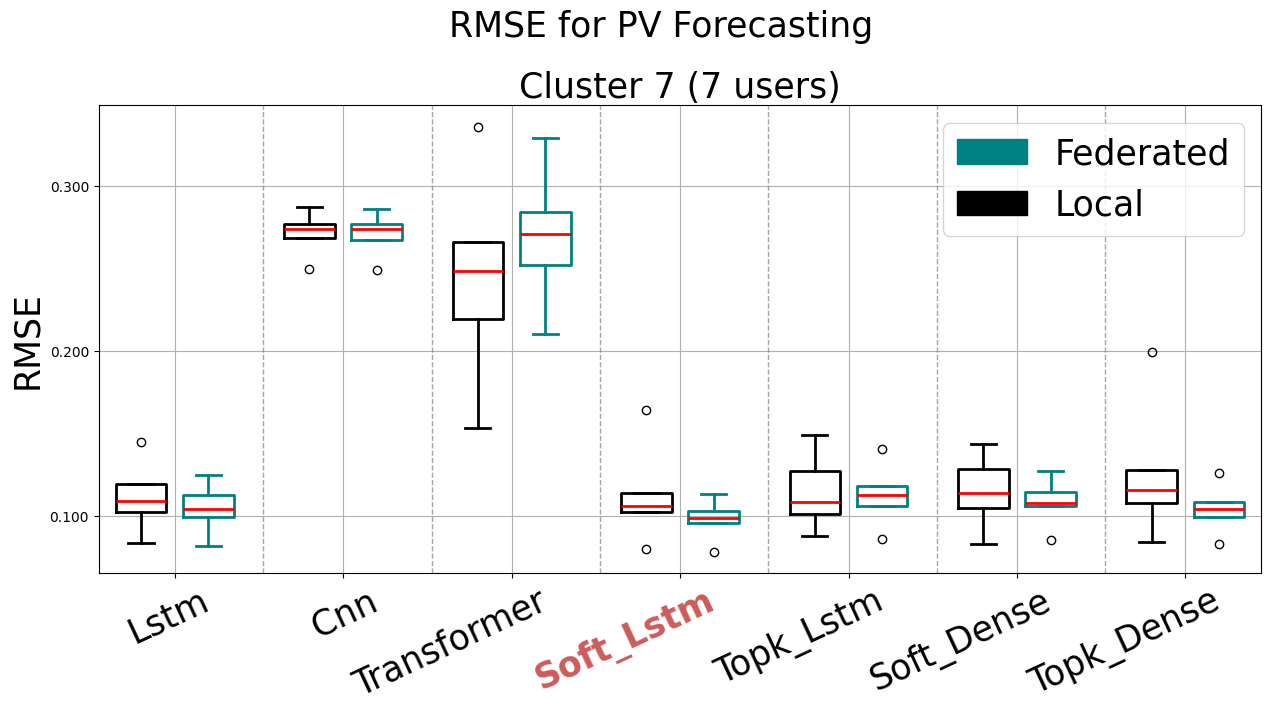

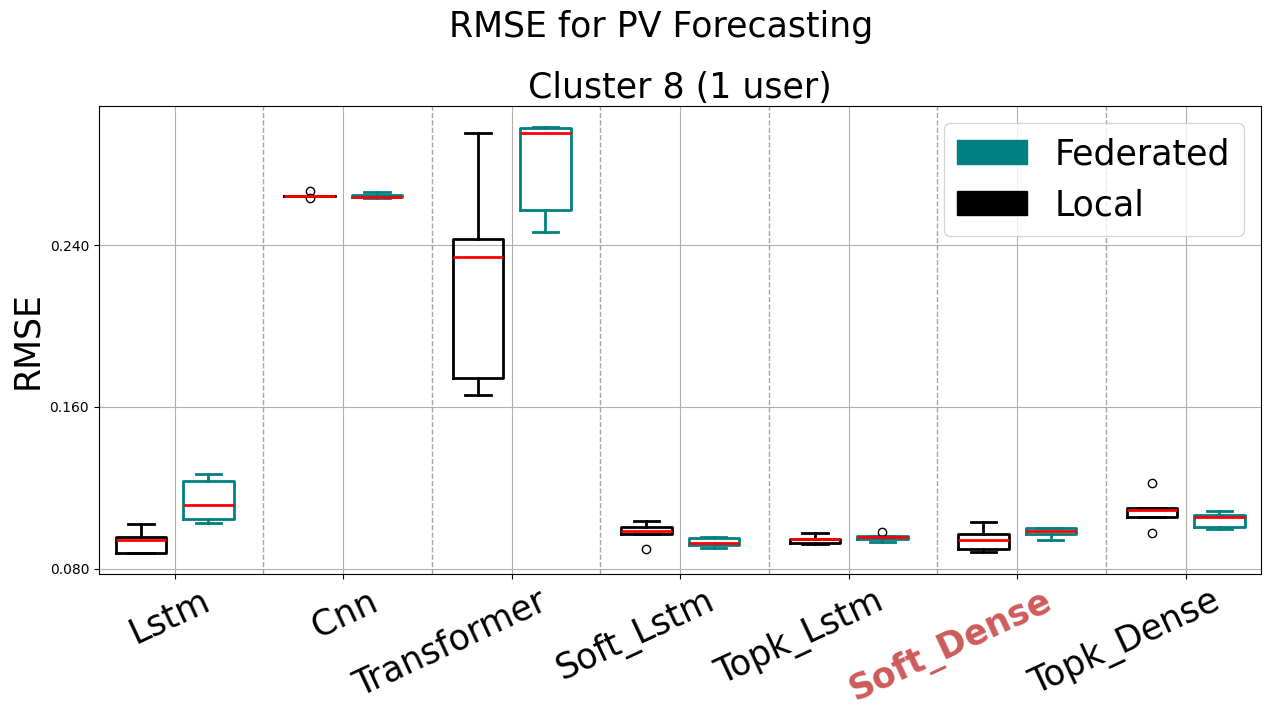

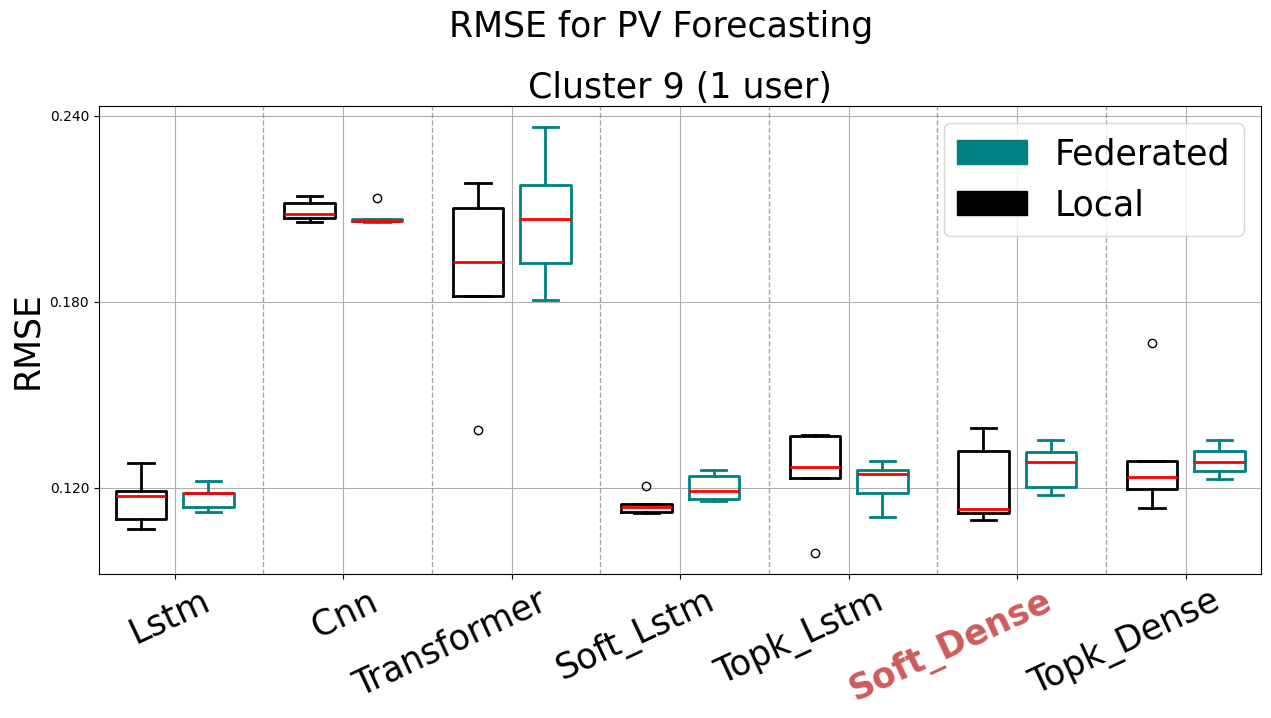

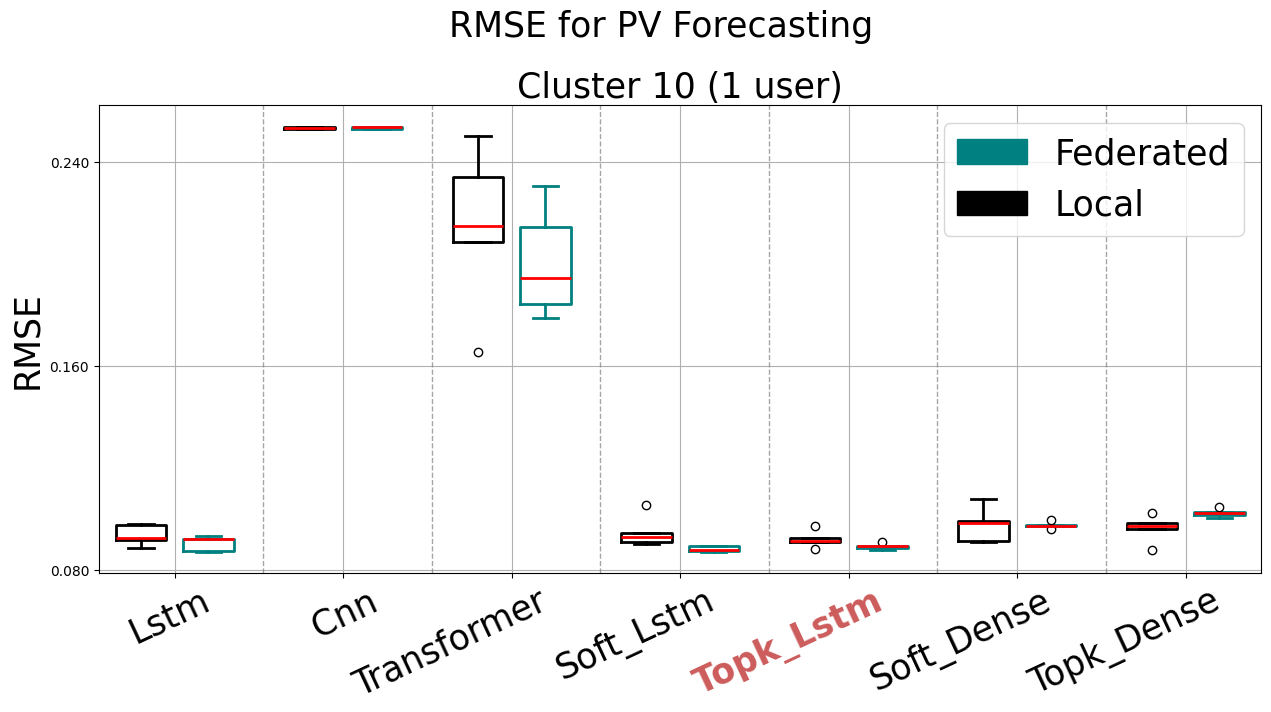

C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\605891211.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


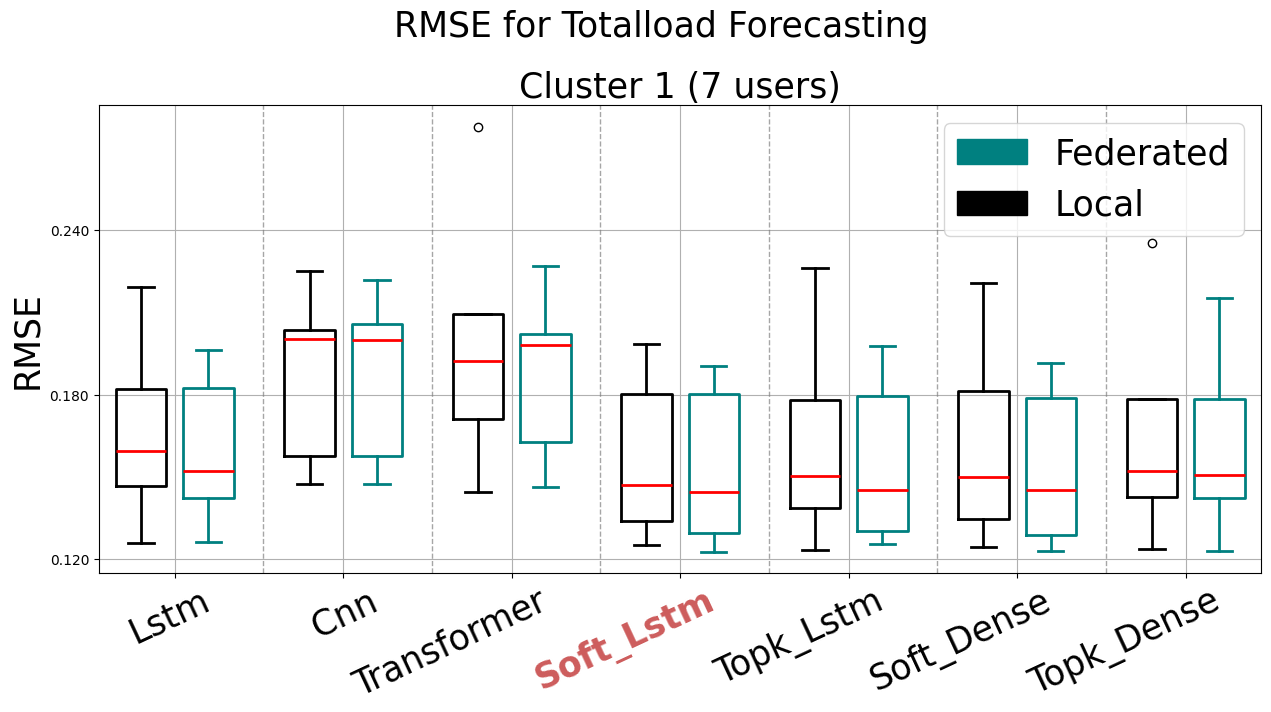

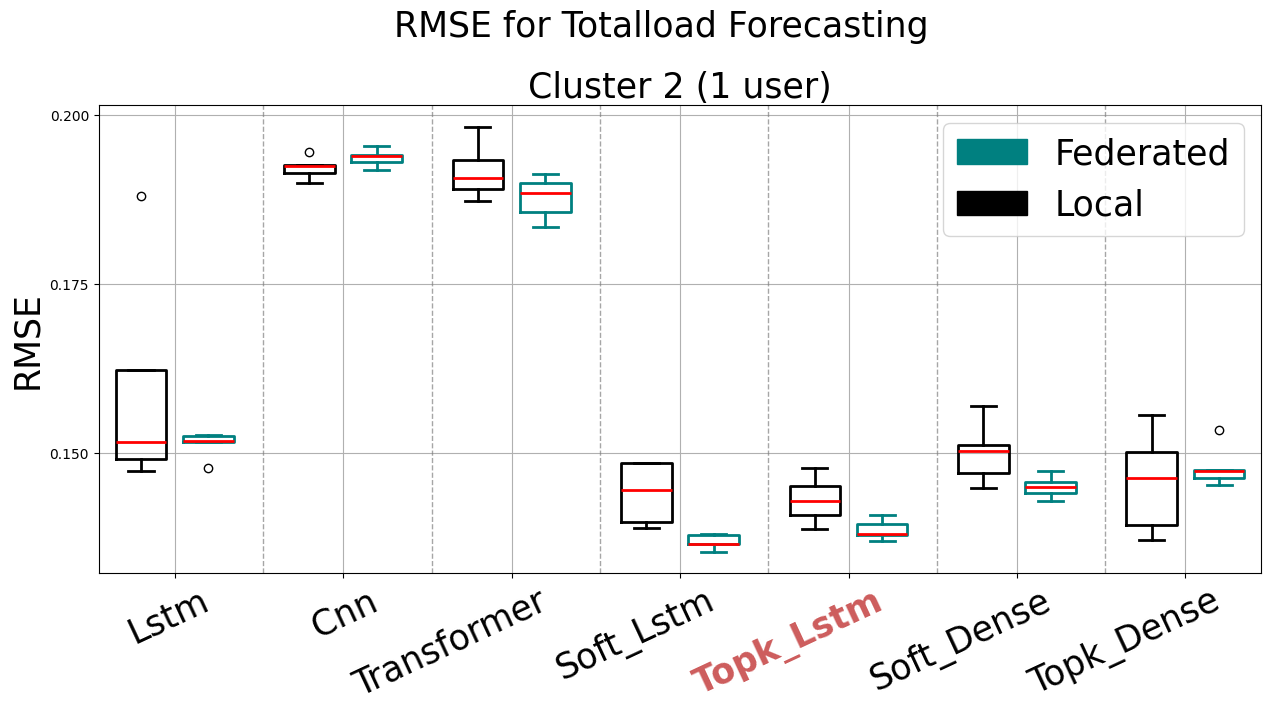

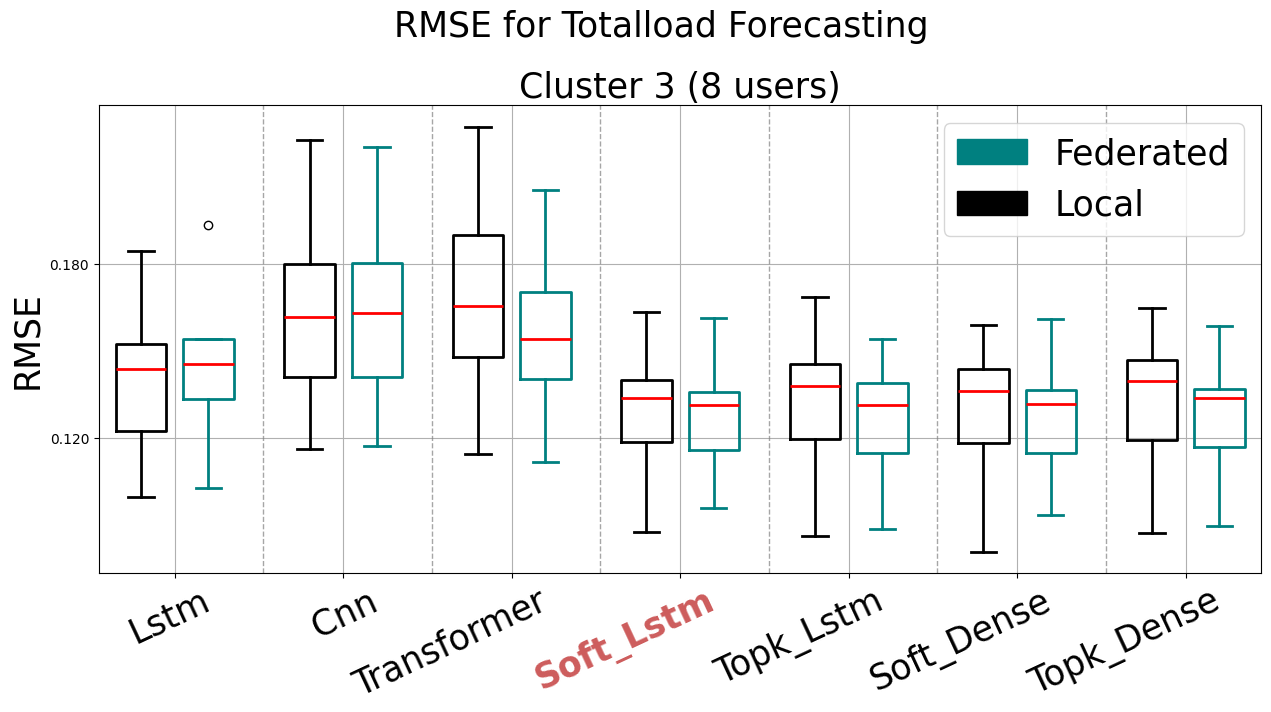

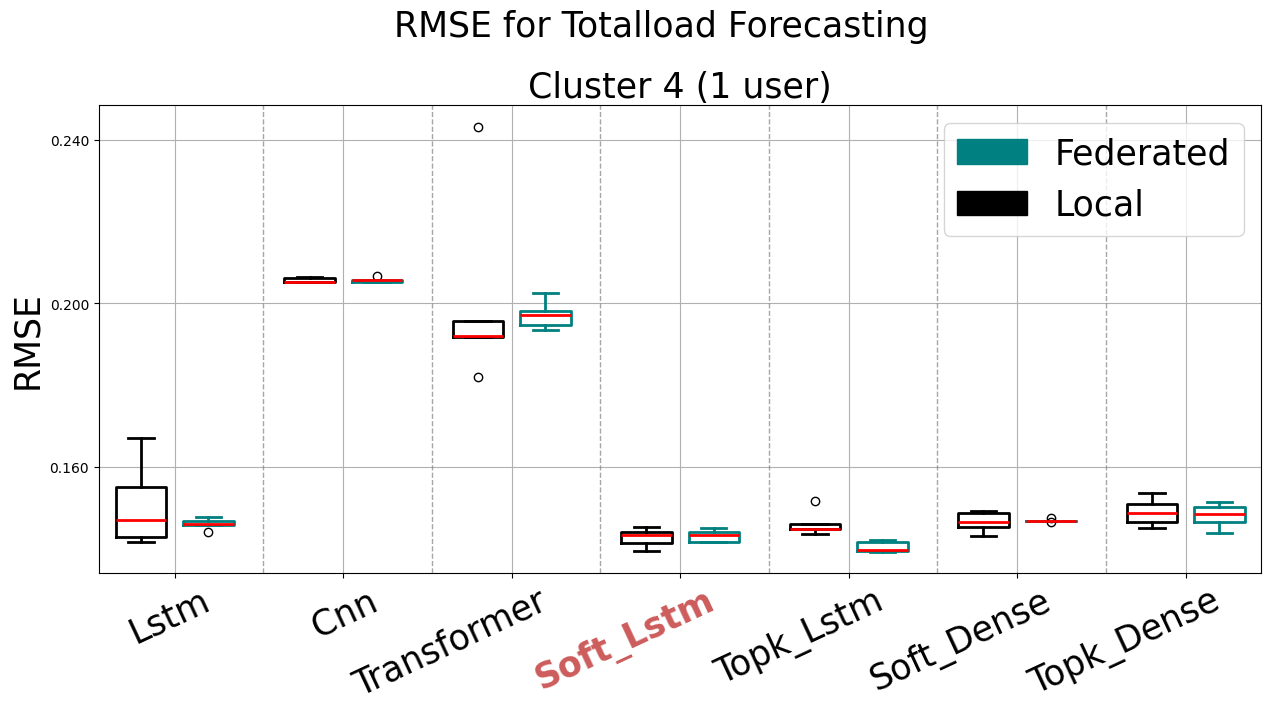

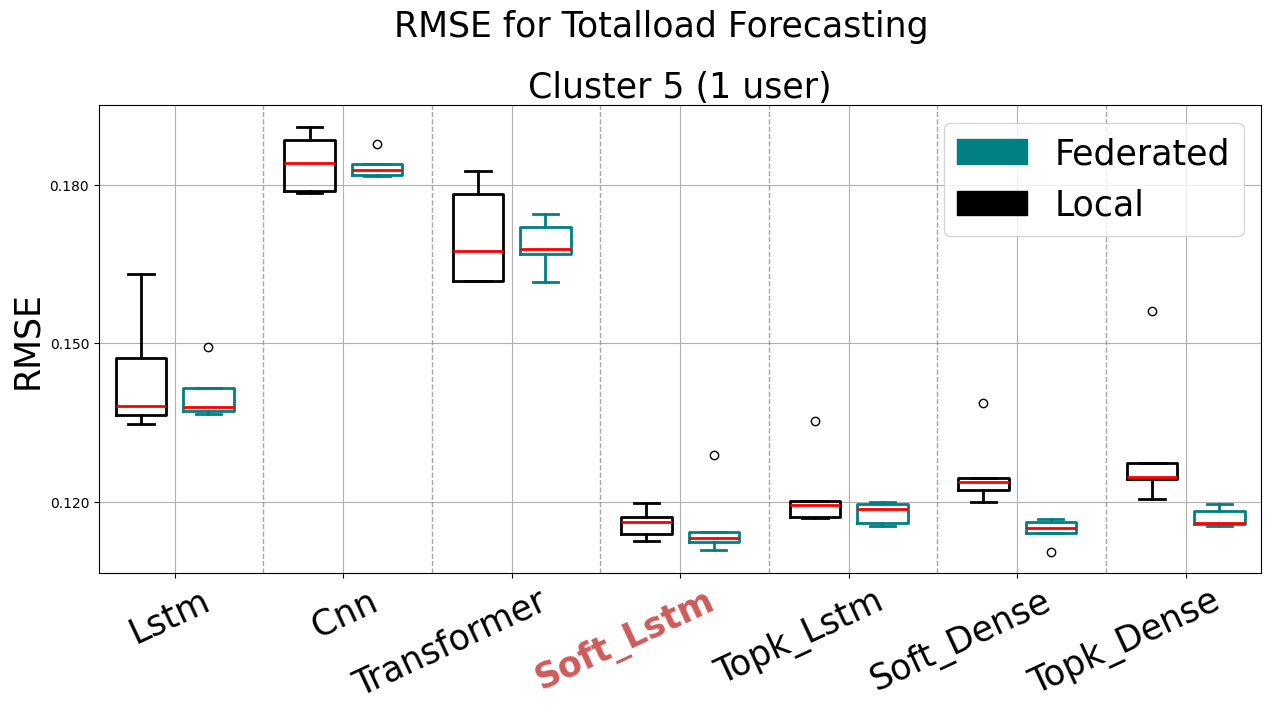

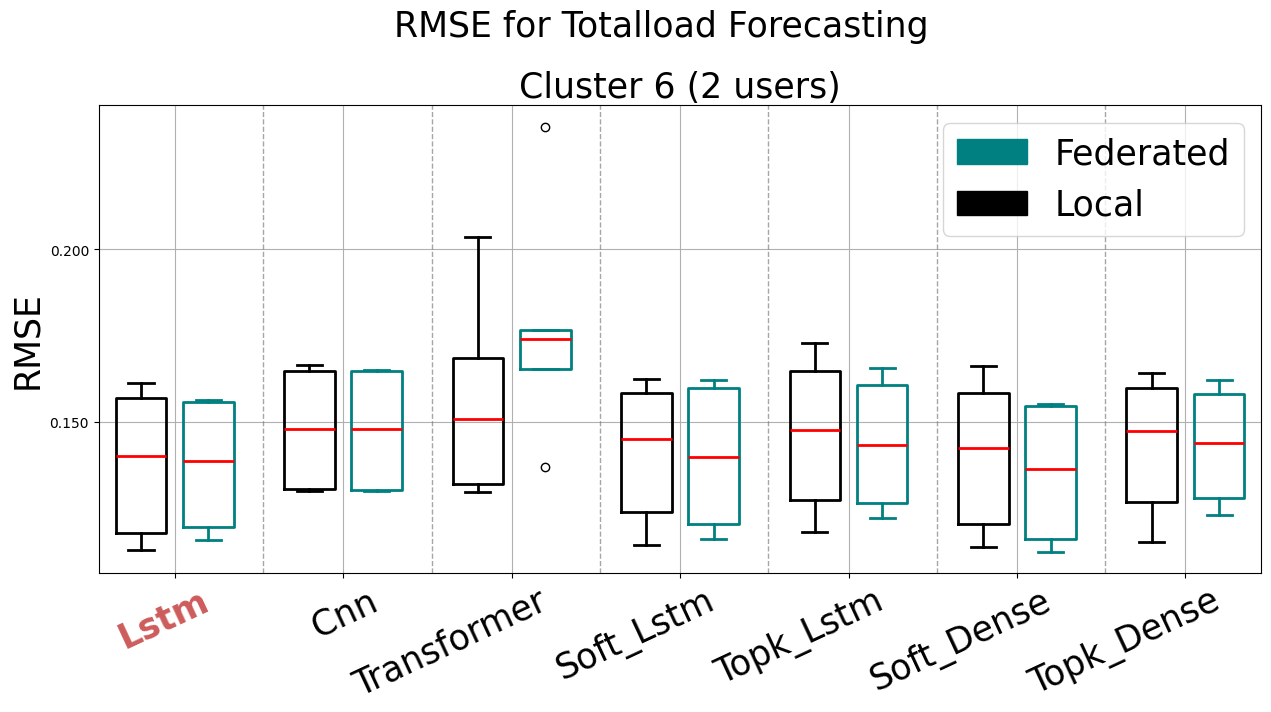

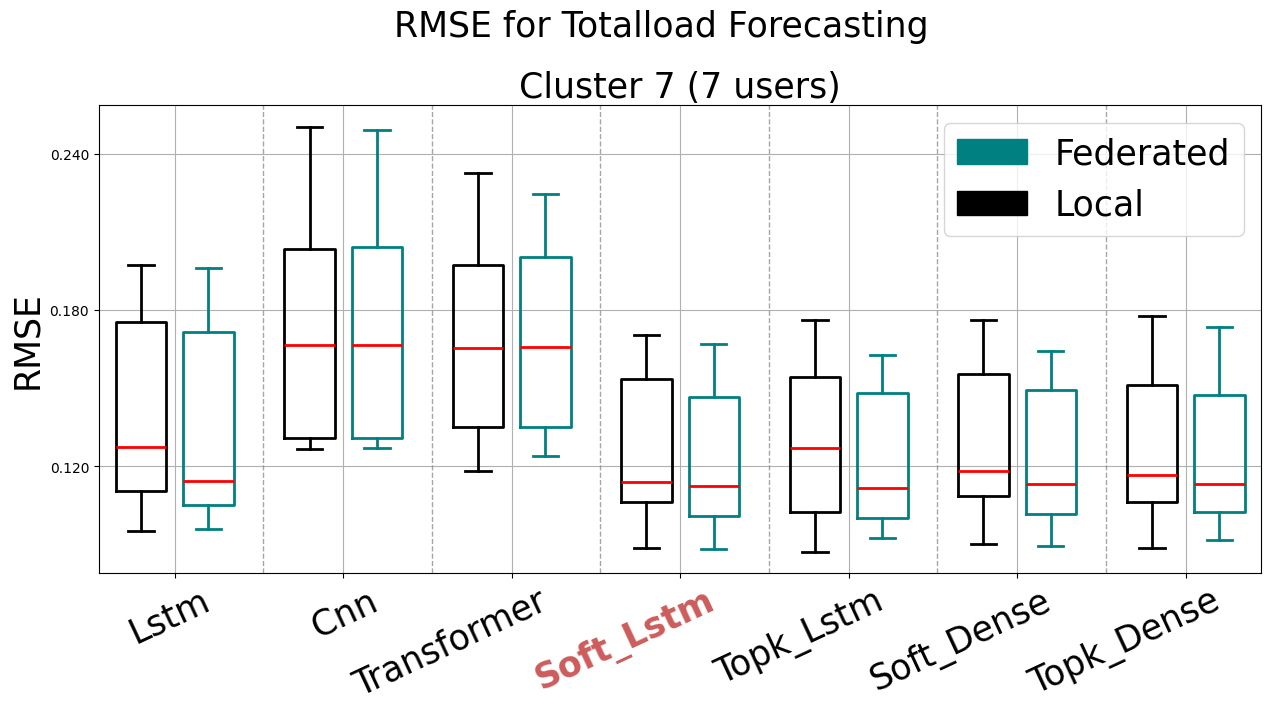

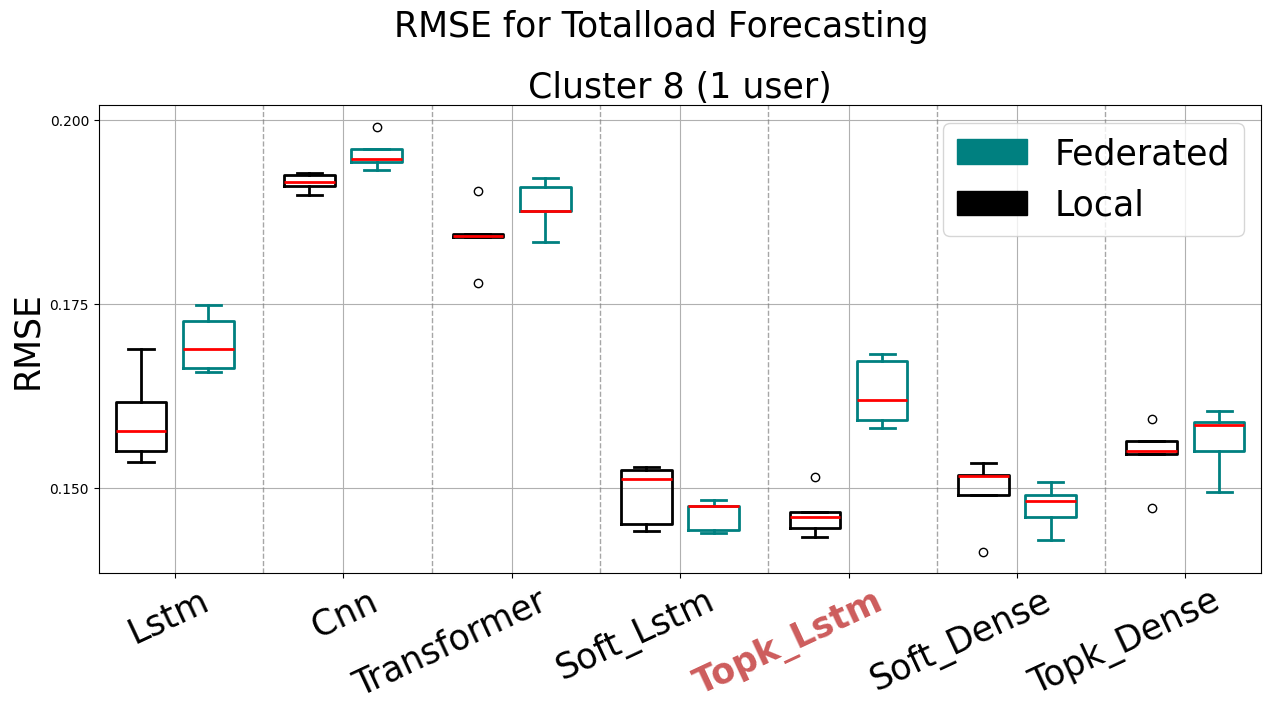

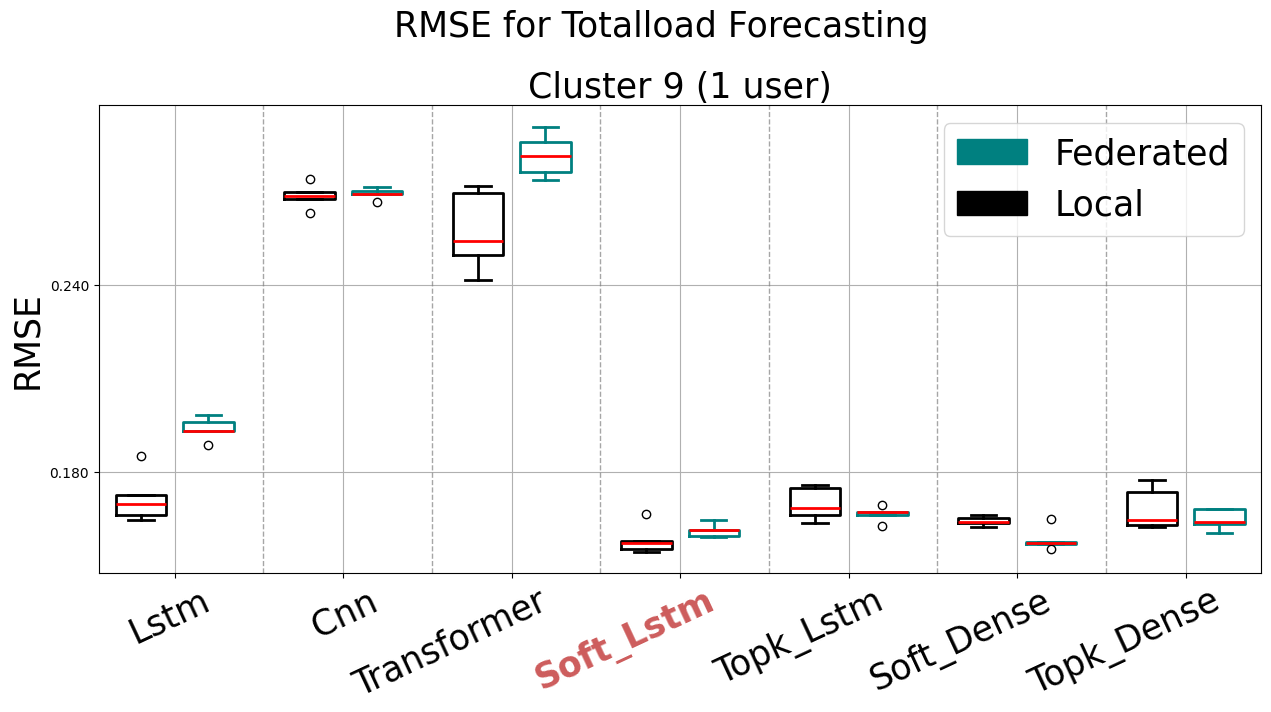

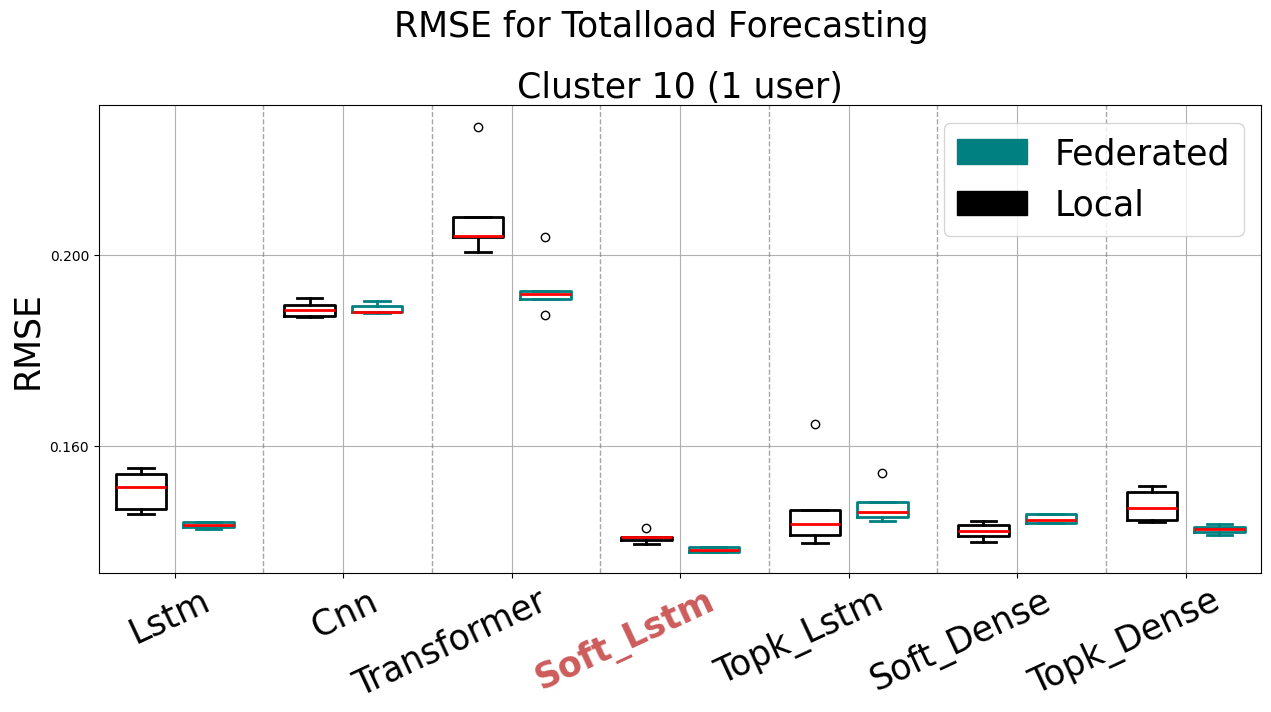

In [18]:
def plot_rmse_boxplot(df_ll, df_fl, num_clusters, use_case, figsize=(15, 6)):
    """
    Function to plot cluster-wise boxplots for RMSE values in the given DataFrames for LL and FL.
    """
    # Shorten model names by removing 'global_' prefix
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    fontsize = 25

    for cluster_number in range(num_clusters):
        cluster_data_ll = df_ll[df_ll['cluster'] == cluster_number]
        cluster_data_fl = df_fl[df_fl['cluster'] == cluster_number]

        # Extract boxplot data for LL and FL
        boxplot_data_ll = cluster_data_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
        boxplot_data_fl = cluster_data_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

        plt.figure(figsize=figsize)
        ax = plt.subplot(111)

        # Plot Local Learning boxplots
        boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        # Plot Federated Learning boxplots in green
        boxplot_data_fl.boxplot(positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

        plt.ylabel('RMSE', fontsize=fontsize)

        x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
        x_labels = boxplot_data_ll.columns
        lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
        for i, label in enumerate(x_labels):
            if label == lowest_median_label:
                ax.get_xticklabels()[i].set_color("indianred")
                ax.get_xticklabels()[i].set_weight("bold")

        offset = 0.4
        for label in ax.get_xticklabels():
            transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
            label.set_transform(transform)

        plt.xticks(x_ticks, x_labels, rotation=25, ha='right', fontsize=fontsize)

        for i in range(1, len(x_ticks)):
            plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

        # Set y-axis format
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        plt.title(f'Cluster {cluster_number+1} ({len(cluster_users[cluster_number])} {"user" if len(cluster_users[cluster_number]) == 1 else "users"})', y=1, fontsize=fontsize)
        plt.ylabel('RMSE', fontsize=fontsize)

        plt.suptitle(get_plot_title(use_case), fontsize=fontsize, y=1.05)
        plt.subplots_adjust(hspace=2, top=0.89)  # Increase space between rows
        teal_patch = mpatches.Patch(color='teal', label='Federated')
        black_patch = mpatches.Patch(color='black', label='Local')
        plt.legend(handles=[teal_patch, black_patch], fontsize=fontsize, loc='upper right')
        plt.show()

# Assuming you have separate DataFrames df_ll and df_fl for LL and FL metrics
num_clusters = 10  # Assuming 10 clusters
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case and each cluster
for use_case in use_cases:
    df_ll_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'LL_{use_case}')]
    df_fl_use_case = combined_average_metrics[combined_average_metrics['model_type'].str.contains(f'FL_{use_case}')]
    plot_rmse_boxplot(df_ll_use_case, df_fl_use_case, num_clusters, use_case)


# 2. Total results

In [19]:
# Load and process all DataFrames
all_results = []
for category, paths in file_paths.items():
    for path in paths:
        df = load_csv(path)
        processed_df = process_dataframe(df, scenario=category, metric='rmse')
        all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)

In [20]:
#model_type = FL_Grossload, LL_Grossload, FL_Prosumption, LL_Prosumption, FL_PV, LL_PV, FL_Totalload, LL_Totalload
df_grossload = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Grossload")]
df_prosumption = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Prosumption")]
df_pv = combined_average_metrics[combined_average_metrics['model_type'].str.contains("PV")]
df_totalload = combined_average_metrics[combined_average_metrics['model_type'].str.contains("Totalload")]

In [21]:
def get_plot_title_new(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\1911868178.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
C:\Users\rs1044\AppData\Local\Temp\ipykernel_32024\1911868178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)


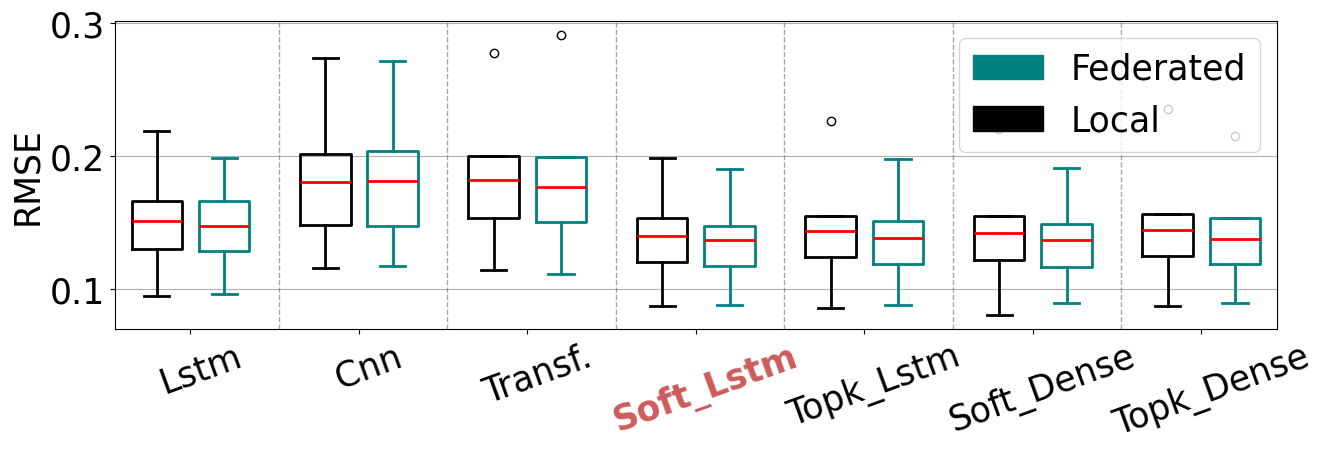

In [34]:
def plot_rmse_boxplot(df_ll, df_fl, title, figsize=(15, 4)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrames for LL and FL.
    """
    df_ll['architecture'] = df_ll['architecture'].apply(standardize_and_simplify_model_names)
    df_fl['architecture'] = df_fl['architecture'].apply(standardize_and_simplify_model_names)

    # Prepare data for boxplot
    boxplot_data_ll = df_ll.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T
    boxplot_data_fl = df_fl.set_index('architecture')[['min', '25%', '50%', '75%', 'max']].T

    fontsize = 25
    # Plotting
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    
    # Plot Local Learning boxplots
    boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    # Plot Federated Learning boxplots in green
    boxplot_data_fl.boxplot(positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    #plt.title(title, fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)
    #plt.ylim(0.050, 0.250)
    ax.tick_params(axis='y', labelsize=fontsize)
    
    x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
    #x_labels = boxplot_data_ll.columns
    x_labels = ['Transf.' if label == 'Transformer' else label for label in boxplot_data_ll.columns]
    # Find the label with the lowest median
    lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
    for i, label in enumerate(x_labels):
        if label == lowest_median_label:
            ax.get_xticklabels()[i].set_color("indianred")
            ax.get_xticklabels()[i].set_weight("bold")
    
    # Define the offset value (adjust this as needed)
    offset = 0.1  # You can change this value to control the offset
    # Offset the x-label text to the left
    for label in ax.get_xticklabels():
        transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
        label.set_transform(transform)

    plt.xticks(x_ticks, x_labels, rotation=20, ha='center', fontsize=fontsize)
    # Add horizontal lines as separation between labels
    for i in range(1, len(x_ticks)):
        plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    
    plt.gca().xaxis.grid(False)
    teal_patch = mpatches.Patch(color='teal', label='Federated')
    black_patch = mpatches.Patch(color='black', label='Local')
    plt.legend(handles=[teal_patch, black_patch], fontsize=fontsize, loc='upper right')
    plt.savefig(f'Figure9_{title}.svg', format='svg', bbox_inches='tight')
    plt.show()

# Use cases
use_cases = ['Totalload']#['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in use_cases:
    df_ll = combined_average_metrics[combined_average_metrics['model_type'].str.contains('LL_' + use_case)]
    df_fl = combined_average_metrics[combined_average_metrics['model_type'].str.contains('FL_' + use_case)]
    title = get_plot_title_new(use_case)
    plot_rmse_boxplot(df_ll, df_fl, title)